In [1]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.2 MB/s eta 0:00:00


In [2]:
!pip install SALib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00


In [3]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [4]:
import pandas as pd
import torch
import SALib
import SALib.sample.finite_diff
import SALib.analyze.dgsm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torcheval import metrics
from torchviz import make_dot

In [5]:
torch.manual_seed(2024)
torch.use_deterministic_algorithms(True)

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU()
        )
        self.out = nn.Linear(hidden_dims[1], output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out(x)
        return x

In [7]:
from sklearn.utils import shuffle

random_shuffle_state = 2024


def shuffle_train_valid_test_split(dataset: TensorDataset, valid_p=0.1, test_p=0.3):
    dataset = TensorDataset(
        *shuffle(*dataset.tensors, random_state=random_shuffle_state))

    train_offset = int(len(dataset) * (1 - (test_p + valid_p)))
    valid_offset = int(len(dataset) * valid_p) + train_offset

    return {
        "train": TensorDataset(*dataset[:train_offset]),
        "valid": TensorDataset(*dataset[train_offset:valid_offset]),
        "test":  TensorDataset(*dataset[valid_offset:])
    }

In [8]:
def model_train(datasets, model, criterion, optimizer):
  losses = []
  val_accuracy = []
  val_losses = []

  train_samples = len(datasets["train"])
  val_samples = len(datasets["valid"])

  train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

  for epoch in range(20):
      running_loss = 0.0

      model.train()
      for inputs, targets in train_loader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      losses.append(running_loss / train_samples)

      model.eval()
      with torch.no_grad():
          inputs, targets = datasets["valid"][:]
          outputs = model(inputs)

          acc = metrics.functional.multiclass_accuracy(outputs, targets)
          loss = criterion(outputs, targets)

          val_accuracy.append(acc)
          val_losses.append(loss / val_samples)
  return losses, val_losses, val_accuracy

In [9]:
def plot_loss_accuracy(dataset_name, losses, val_losses, val_accuracy):
  plt.plot(losses, label=f'{dataset_name} loss')
  plt.plot(val_losses, label=f'{dataset_name} validation loss')
  plt.legend()
  plt.show()
  plt.plot(val_accuracy, label=f'{dataset_name} validation accuracy')
  plt.legend()
  plt.show()

In [10]:
def wrapped_model(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float)
    with torch.no_grad():
        return model(inputs).detach().numpy()

In [11]:
def analyze_dgsm(headers):
  problem = SALib.ProblemSpec({
      "num_vars": len(headers),
      "names": headers,
      "bounds": [[-1., 1.]] * len(headers),
  })

  problem.items()

  problem.sample(SALib.sample.finite_diff.sample, N=1024)
  problem.evaluate(wrapped_model)
  problem.analyze(SALib.analyze.dgsm.analyze)

  print(problem)
  return problem

In [12]:
def analyze_fast(headers):
  problem = SALib.ProblemSpec({
      "num_vars": len(headers),
      "names": headers,
      "bounds": [[-1., 1.]] * len(headers),
  })

  problem.items()

  problem.sample(SALib.sample.fast_sampler.sample, N=1024, seed = 2024)
  problem.evaluate(wrapped_model)
  problem.analyze(SALib.analyze.fast.analyze)

  print(problem)
  return problem

In [13]:
def show_stats(problem, mode="dgsm"):
  stats: pd.DataFrame = sum(problem.to_df())  # sum analysis over target classes
  print(stats)
  min_index = stats[mode].argmin()
  min_index, stats.iloc[min_index]

In [14]:
def dgsm_remove_headers(datasets, headers, model_factory, optimizer_factory, criterion):
  dropped_headers = []

  test_accs = []

  models = []

  # removing features loop
  while len(headers) > 0:
      model = model_factory(headers)
      optimizer = optimizer_factory(model)

      losses = []
      val_accuracy = []
      val_losses = []

      train_samples = len(datasets["train"])
      val_samples = len(datasets["valid"])

      train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

      for epoch in range(20):
          running_loss = 0.0

          model.train()
          for inputs, targets in train_loader:
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()

          losses.append(running_loss / train_samples)

          model.eval()
          with torch.no_grad():
              inputs, targets = datasets["valid"][:]
              outputs = model(inputs)

              acc = metrics.functional.multiclass_accuracy(outputs, targets)
              loss = criterion(outputs, targets)

              val_accuracy.append(acc.item())
              val_losses.append(loss.item() / val_samples)

      with torch.no_grad():
          inputs, targets = datasets["test"][:]
          outputs = model(inputs)

          test_loss = criterion(outputs, targets)
          test_acc = metrics.functional.multiclass_accuracy(outputs, targets)

      test_accs.append(test_acc.item())
      models.append(model)

      # feel free to edit
      plt.gcf().set_figwidth(10)
      plt.subplot(1, 2, 1)
      plt.plot(losses, label="loss")
      plt.plot(val_losses, label="validation loss")
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(val_accuracy, label="validation accuracy")
      plt.ylim(0, 1)
      plt.legend()
      plt.show()

      print(f"Test: loss: {test_loss}, accuracy: {test_acc}")

      # sensitive analysis
      if len(headers) <= 1:
          break

      def wrapped_model(inputs):
          inputs = torch.tensor(inputs, dtype=torch.float)
          with torch.no_grad():
              return model(inputs).detach().numpy()

      problem = SALib.ProblemSpec({
          "num_vars": len(headers),
          "names": headers,
          "bounds": [[-1., 1.]] * len(headers),
          "dists": ["norm"] * len(headers)
      })

      problem.sample(SALib.sample.finite_diff.sample, N=4096)
      problem.evaluate(wrapped_model)
      problem.analyze(SALib.analyze.dgsm.analyze)

      min_index = sum(problem.to_df())['dgsm'].argmin()

      indexes = torch.arange(len(headers)) != min_index
      datasets = {
          key: TensorDataset(
              dataset.tensors[0][:, indexes],
              dataset.tensors[1]
          )
          for key, dataset in datasets.items()
      }

      dropped_headers.append((min_index, headers[min_index]))
      print(f"dropping feature: {dropped_headers[-1]}")
      del headers[min_index]

      print("="*50)
  return test_accs, dropped_headers, models

In [15]:
def fast_remove_headers(datasets, headers, model_factory, optimizer_factory, criterion):
  dropped_headers = []

  test_accs = []

  models = []

  # removing features loop
  while len(headers) > 0:
      model = model_factory(headers)
      optimizer = optimizer_factory(model)

      losses = []
      val_accuracy = []
      val_losses = []

      train_samples = len(datasets["train"])
      val_samples = len(datasets["valid"])

      train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

      for epoch in range(20):
          running_loss = 0.0

          model.train()
          for inputs, targets in train_loader:
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()

          losses.append(running_loss / train_samples)

          model.eval()
          with torch.no_grad():
              inputs, targets = datasets["valid"][:]
              outputs = model(inputs)

              acc = metrics.functional.multiclass_accuracy(outputs, targets)
              loss = criterion(outputs, targets)

              val_accuracy.append(acc.item())
              val_losses.append(loss.item() / val_samples)

      with torch.no_grad():
          inputs, targets = datasets["test"][:]
          outputs = model(inputs)

          test_loss = criterion(outputs, targets)
          test_acc = metrics.functional.multiclass_accuracy(outputs, targets)

      test_accs.append(test_acc.item())
      models.append(model)

      # feel free to edit
      plt.gcf().set_figwidth(10)
      plt.subplot(1, 2, 1)
      plt.plot(losses, label="loss")
      plt.plot(val_losses, label="validation loss")
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(val_accuracy, label="validation accuracy")
      plt.ylim(0, 1)
      plt.legend()
      plt.show()

      print(f"Test: loss: {test_loss}, accuracy: {test_acc}")

      # sensitive analysis
      if len(headers) <= 1:
          break

      def wrapped_model(inputs):
          inputs = torch.tensor(inputs, dtype=torch.float)
          with torch.no_grad():
              return model(inputs).detach().numpy()

      problem = SALib.ProblemSpec({
          "num_vars": len(headers),
          "names": headers,
          "bounds": [[-1., 1.]] * len(headers),
          "dists": ["norm"] * len(headers)
      })

      problem.sample(SALib.sample.fast_sampler.sample, N=1024, seed = 2024)
      problem.evaluate(wrapped_model)
      problem.analyze(SALib.analyze.fast.analyze)

      min_index = sum(problem.to_df())['ST'].argmin()

      indexes = torch.arange(len(headers)) != min_index
      datasets = {
          key: TensorDataset(
              dataset.tensors[0][:, indexes],
              dataset.tensors[1]
          )
          for key, dataset in datasets.items()
      }

      dropped_headers.append((min_index, headers[min_index]))
      print(f"dropping feature: {dropped_headers[-1]}")
      del headers[min_index]

      print("="*50)
  return test_accs, dropped_headers, models

In [16]:
def dgsm_remove_neurons(datasets, initial_hidden_size, model_factory, optimizer_factory, criterion):
  hidden_size = initial_hidden_size
  dropped_neurons = []
  test_accs = []
  models = []

  # removing features loop
  while hidden_size > 0:
      model = model_factory(1, hidden_size)
      model.layer1 = nn.Identity()
      # model.load_state_dict(state_dict)

      optimizer = optimizer_factory(model)

      losses = []
      val_accuracy = []
      val_losses = []

      train_samples = len(datasets["train"])
      val_samples = len(datasets["valid"])

      train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

      for epoch in range(20):
          running_loss = 0.0

          model.train()
          for inputs, targets in train_loader:
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()

          losses.append(running_loss / train_samples)

          model.eval()
          with torch.no_grad():
              inputs, targets = datasets["valid"][:]
              outputs = model(inputs)

              acc = metrics.functional.multiclass_accuracy(outputs, targets)
              loss = criterion(outputs, targets)

              val_accuracy.append(acc.item())
              val_losses.append(loss.item() / val_samples)

      with torch.no_grad():
          inputs, targets = datasets["test"][:]
          outputs = model(inputs)

          test_loss = criterion(outputs, targets)
          test_acc = metrics.functional.multiclass_accuracy(outputs, targets)

      test_accs.append(test_acc.item())
      models.append(model)

      # feel free to edit
      plt.gcf().set_size_inches(10, 5)
      plt.subplot(1, 2, 1)
      plt.plot(losses, label="loss")
      plt.plot(val_losses, label="validation loss")
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(val_accuracy, label="validation accuracy")
      plt.legend()
      plt.show()

      print(f"dropped: {len(dropped_neurons)}, test: loss: {test_loss}, accuracy: {test_acc}")

      # sensitive analysis
      if hidden_size <= 1:
          break

      def wrapped_model(inputs):
          inputs = torch.tensor(inputs, dtype=torch.float)
          with torch.no_grad():
              return model(inputs).detach().numpy()

      problem = SALib.ProblemSpec({
          "num_vars": hidden_size,
          "names": [f"x{i}" for i in range(hidden_size)],
          "bounds": [[-1., 1.]] * hidden_size,
      })

      problem.sample(SALib.sample.finite_diff.sample, N=2048)
      problem.evaluate(wrapped_model)
      problem.analyze(SALib.analyze.dgsm.analyze)

      min_index = sum(problem.to_df())['dgsm'].argmin()

      indexes = torch.arange(hidden_size) != min_index
      datasets = {
          key: TensorDataset(
              dataset.tensors[0][:, indexes],
              dataset.tensors[1]
          )
          for key, dataset in datasets.items()
      }

      dropped_neurons.append(min_index)
      hidden_size -= 1

      print("="*50)
  return test_accs, dropped_neurons, models

In [17]:
def fast_remove_neurons(datasets, initial_hidden_size, model_factory, optimizer_factory, criterion, is_layer_1 = True):
  hidden_size = initial_hidden_size
  dropped_neurons = []
  test_accs = []
  models = []

  # removing features loop
  while hidden_size > 0:
      model = model_factory(1, hidden_size)
      model.layer1 = nn.Identity()
      # model.load_state_dict(state_dict)
      optimizer = optimizer_factory(model)

      losses = []
      val_accuracy = []
      val_losses = []

      train_samples = len(datasets["train"])
      val_samples = len(datasets["valid"])
      train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

      for epoch in range(20):
          running_loss = 0.0

          model.train()
          for inputs, targets in train_loader:
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()

          losses.append(running_loss / train_samples)
          model.eval()
          with torch.no_grad():
              inputs, targets = datasets["valid"][:]
              outputs = model(inputs)

              acc = metrics.functional.multiclass_accuracy(outputs, targets)
              loss = criterion(outputs, targets)

              val_accuracy.append(acc.item())
              val_losses.append(loss.item() / val_samples)
      with torch.no_grad():
          inputs, targets = datasets["test"][:]
          outputs = model(inputs)

          test_loss = criterion(outputs, targets)
          test_acc = metrics.functional.multiclass_accuracy(outputs, targets)

      test_accs.append(test_acc.item())
      models.append(model)
      # feel free to edit
      plt.gcf().set_size_inches(10, 5)
      plt.subplot(1, 2, 1)
      plt.plot(losses, label="loss")
      plt.plot(val_losses, label="validation loss")
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(val_accuracy, label="validation accuracy")
      plt.legend()
      plt.show()

      print(f"dropped: {len(dropped_neurons)}, test: loss: {test_loss}, accuracy: {test_acc}")

      # sensitive analysis
      if hidden_size <= 1:
          break

      def wrapped_model(inputs):
          inputs = torch.tensor(inputs, dtype=torch.float)
          with torch.no_grad():
              return model(inputs).detach().numpy();

      problem = None
      if is_layer_1:
        problem = SALib.ProblemSpec({
          "num_vars": hidden_size,
          "names": [f"x{i}" for i in range(hidden_size)],
          "bounds": [[-1., 1.]] * hidden_size,
        })
      else:
        problem = SALib.ProblemSpec({
          "num_vars": initial_hidden_size,
          "names": [f"x{i}" for i in range(initial_hidden_size)],
          "bounds": [[-1., 1.]] * initial_hidden_size,
        })
      problem.sample(SALib.sample.fast_sampler.sample, N=2048, seed = 2024)
      problem.evaluate(wrapped_model)
      problem.analyze(SALib.analyze.fast.analyze)

      min_index = sum(problem.to_df())['ST'].argmin()

      indexes = torch.arange(hidden_size) != min_index
      if is_layer_1:
        datasets = {
          key: TensorDataset(
              dataset.tensors[0][:, indexes],
              dataset.tensors[1]
          )
          for key, dataset in datasets.items()
        }

      dropped_neurons.append(min_index)
      hidden_size -= 1

      print("="*50)
  return test_accs, dropped_neurons, models

In [18]:
def pick_features_to_drop(headers, dropped_headers, models, datasets, num_drop_features):
  reduced_headers = headers.copy()
  indexes = list(range(len(reduced_headers)))
  for idx, _ in dropped_headers[:num_drop_features]:
      del indexes[idx]
      del reduced_headers[idx]

  reduced_datasets = {
      key: TensorDataset(
          dataset.tensors[0][:, indexes],
          dataset.tensors[1]
      )
      for key, dataset in datasets.items()
  }

  best_model = models[num_drop_features]

  print(f"[{len(reduced_headers)}] features left:", reduced_headers)

  return best_model, reduced_datasets

In [73]:
def pick_neurons_to_drop(num_drop_neurons, hidden_size, dropped_neurons, best_model, models, layer_num = 1):
  indexes = list(range(hidden_size))
  for idx in dropped_neurons[:num_drop_neurons]:
      del indexes[idx]
  reduced_datasets = {
    key: TensorDataset(
        dataset.tensors[0][:, indexes],
        dataset.tensors[1]
    )
    for key, dataset in datasets.items()
  }

  layer1 = best_model.layer1
  state_dict = layer1[0].state_dict()
  layer1[0] = nn.Linear(
      in_features=layer1[0].in_features,
      out_features=len(indexes)
  )
  state_dict["bias"] = state_dict["bias"][indexes]
  state_dict["weight"] = state_dict["weight"][indexes, :]
  layer1[0].load_state_dict(state_dict)

  new_best_model = models[num_drop_neurons]
  new_best_model.layer1 = layer1

  # TO_FINISH!!
  # if layer_num == 2:
  #   layer2 = best_model.layer2
  #   state_dict = layer2[0].state_dict()
  #   layer2[0] = nn.Linear(
  #       in_features=layer2[0].in_features,
  #       out_features=len(indexes)
  #   )
  #   print(indexes)
  #   state_dict["bias"] = state_dict["bias"][indexes]
  #   state_dict["weight"] = state_dict["weight"][indexes, :]
  #   layer2[0].load_state_dict(state_dict)

  #   new_best_model = models[num_drop_neurons]
  #   new_best_model.layer2 = layer2
  return new_best_model, reduced_datasets

In [20]:
def model_pre_train(base_model, criterion, optimizer_factory, datasets):
  base_model.layer1 = nn.Identity()

  train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

  optimizer = optimizer_factory(base_model)

  # pretrain
  base_model.train()
  for epoch in range(5):
      for inputs, targets in train_loader:
          optimizer.zero_grad()
          outputs = base_model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()

In [23]:
# import breast cancer dataset
data = pd.read_csv('banana_quality.csv')

X = data.drop('Quality', axis=1)
y = data['Quality']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [29]:
banana_scaler = StandardScaler()
banana_dataset = TensorDataset(
    torch.tensor(banana_scaler.fit_transform(X), dtype=torch.float),
    torch.tensor(y, dtype=torch.long).flatten()
)

banana_datasets = shuffle_train_valid_test_split(banana_dataset)
banana_headers: list = X.keys().to_list()

In [31]:
datasets = banana_datasets

model = MLP(X.shape[1], (32, 32), 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
losses, val_losses, val_accuracy = model_train(datasets, model, criterion, optimizer)

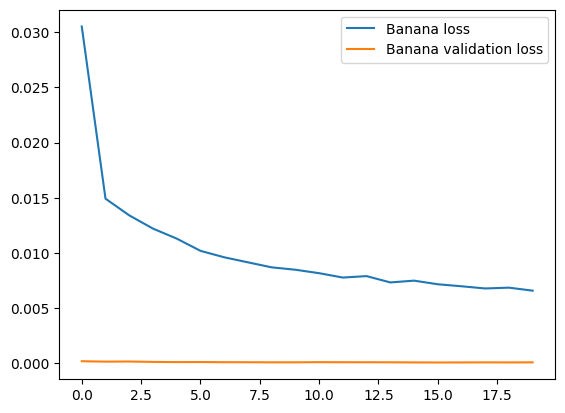

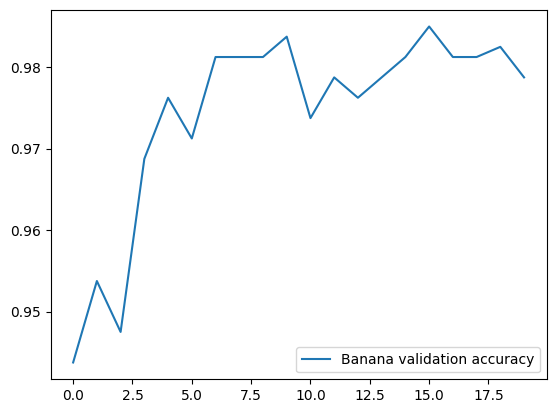

In [33]:
plot_loss_accuracy('Banana', losses, val_losses, val_accuracy)

## DGSM

In [34]:
problem = analyze_dgsm(banana_headers)
show_stats(problem)
datasets = banana_datasets.copy()
headers = banana_headers.copy()
model_factory = lambda headers : MLP(len(headers), (32, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Samples:
	7 parameters: ['Size', 'Weight', 'Sweetness', 'Softness', 'HarvestTime', 'Ripeness', 'Acidity']
	8192 samples
Outputs:
	2 outputs: ['Y1', 'Y2']
	8192 evaluations
Analysis:
Y1:
                   vi    vi_std      dgsm  dgsm_conf
Size         0.679502  0.866104  0.145010   0.055524
Weight       2.926497  3.439474  0.624531   0.215643
Sweetness    1.715945  2.686261  0.366193   0.160501
Softness     2.009994  3.032311  0.428944   0.164541
HarvestTime  1.926166  2.498065  0.411055   0.146387
Ripeness     1.014153  1.505463  0.216426   0.089741
Acidity      2.205818  2.722539  0.470734   0.186580:
Y2:
                   vi    vi_std      dgsm  dgsm_conf
Size         0.550169  0.708647  0.134874   0.037372
Weight       2.483489  2.991009  0.608826   0.175156
Sweetness    1.410165  2.144547  0.345701   0.138067
Softness     1.870406  2.875237  0.458529   0.158190
HarvestTime  1.814633  2.397566  0.444856   0.146454
Ripeness     0.933360  1.417127  0.228813   0.092117
Acidity      2

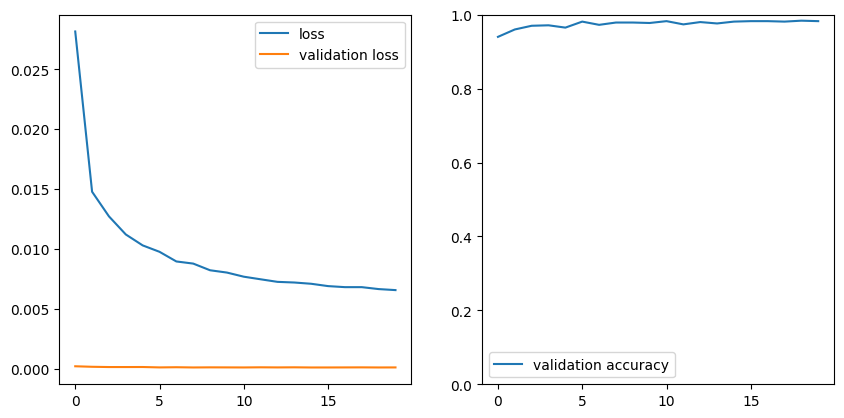

Test: loss: 0.07725637406110764, accuracy: 0.981249988079071
dropping feature: (3, 'Softness')


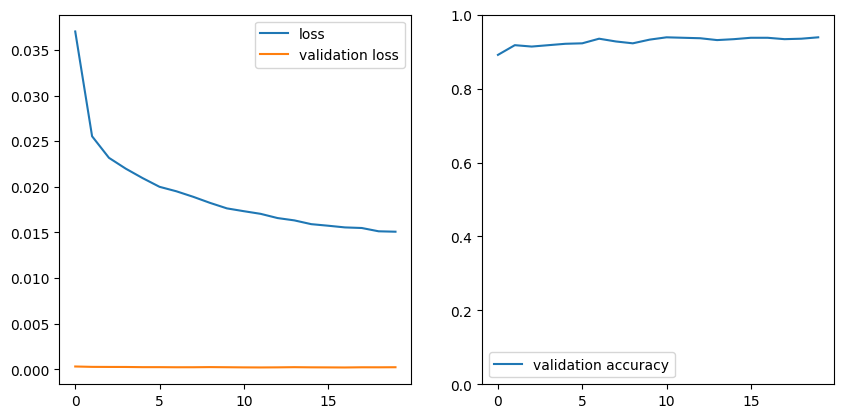

Test: loss: 0.1652148962020874, accuracy: 0.9420833587646484
dropping feature: (4, 'Ripeness')


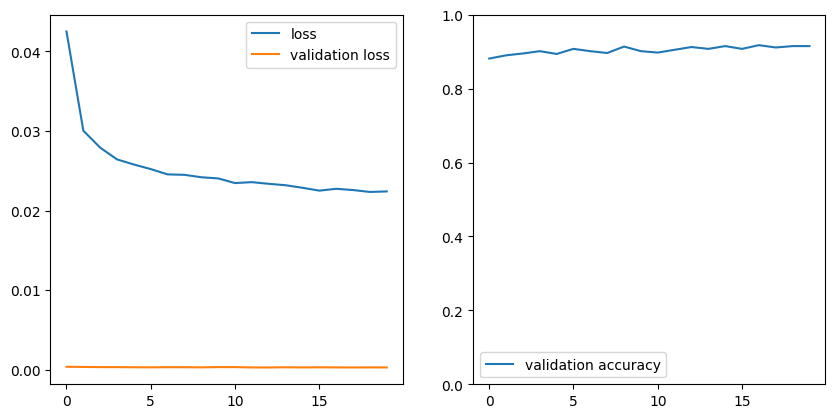

Test: loss: 0.21498197317123413, accuracy: 0.9125000238418579
dropping feature: (0, 'Size')


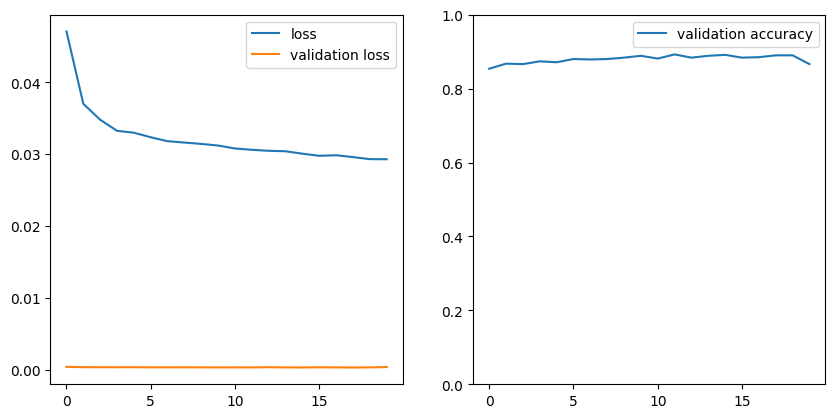

Test: loss: 0.29374322295188904, accuracy: 0.8704166412353516
dropping feature: (1, 'Sweetness')


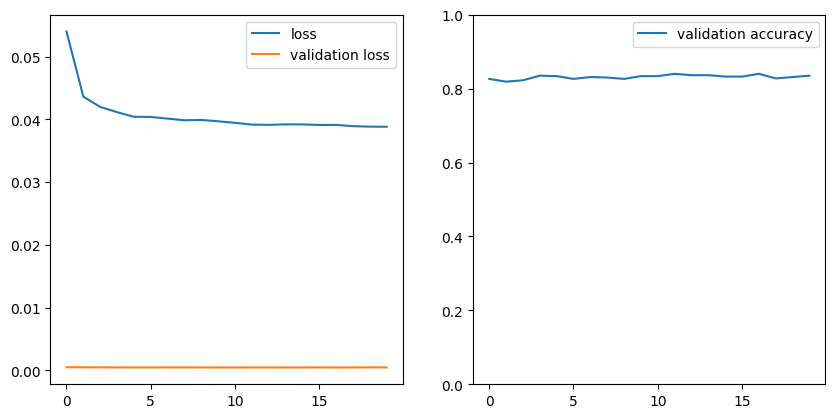

Test: loss: 0.32607296109199524, accuracy: 0.8487499952316284
dropping feature: (1, 'HarvestTime')


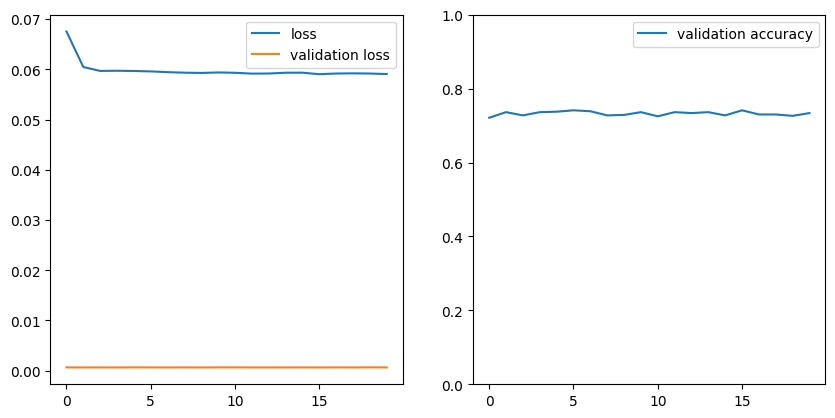

Test: loss: 0.4793061912059784, accuracy: 0.7325000166893005
dropping feature: (0, 'Weight')


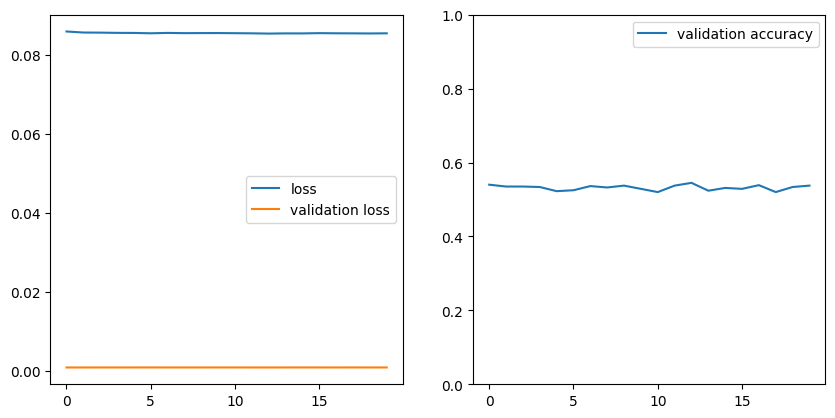

Test: loss: 0.6821609735488892, accuracy: 0.5633333325386047


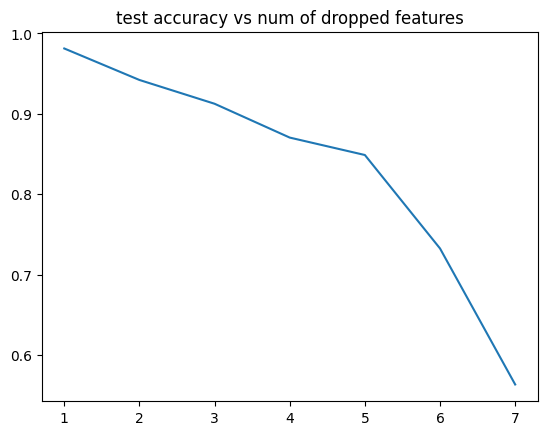

In [35]:
test_accs, dropped_headers, models = dgsm_remove_headers(datasets, headers, model_factory, optimizer_factory ,criterion)
plt.plot(range(1, len(test_accs)+1), test_accs)
plt.title("test accuracy vs num of dropped features")
plt.show()

In [36]:
reduced_headers = banana_headers.copy()
datasets = banana_datasets
num_drop_features = 1
best_model, reduced_datasets = pick_features_to_drop(reduced_headers, dropped_headers, models, datasets, num_drop_features)

[6] features left: ['Size', 'Weight', 'Sweetness', 'HarvestTime', 'Ripeness', 'Acidity']


In [37]:
layer: nn.Module = best_model.layer1
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

In [38]:
# not needed in this model, maybe usefull in bigger one to save some traning time? to be tested
# will need acrobatics for sure (tweaking state_dict)
base_model = MLP(len(banana_headers), (32, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_pre_train(base_model, criterion, optimizer_factory, datasets)

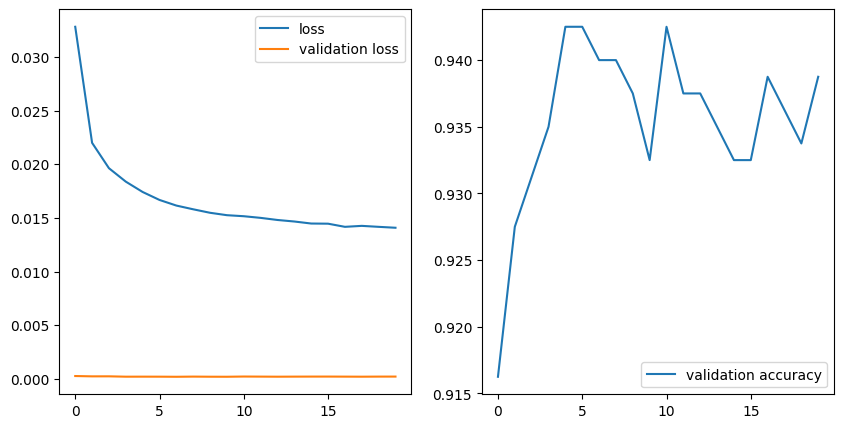

dropped: 0, test: loss: 0.1483612358570099, accuracy: 0.9487500190734863


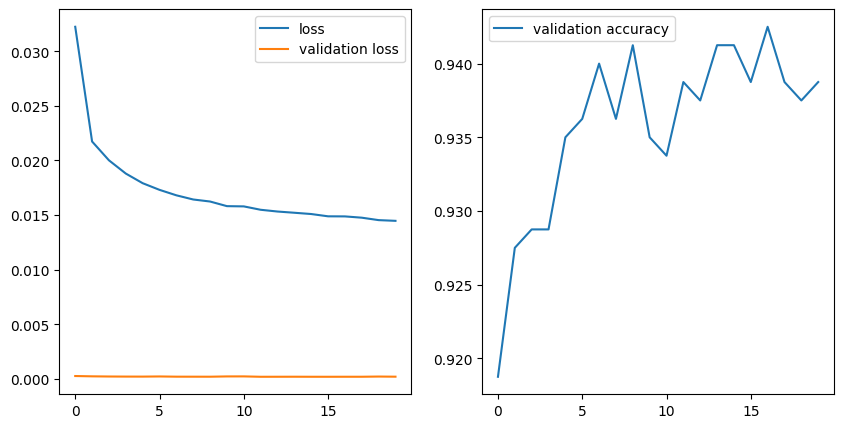

dropped: 1, test: loss: 0.1466648429632187, accuracy: 0.9483333230018616


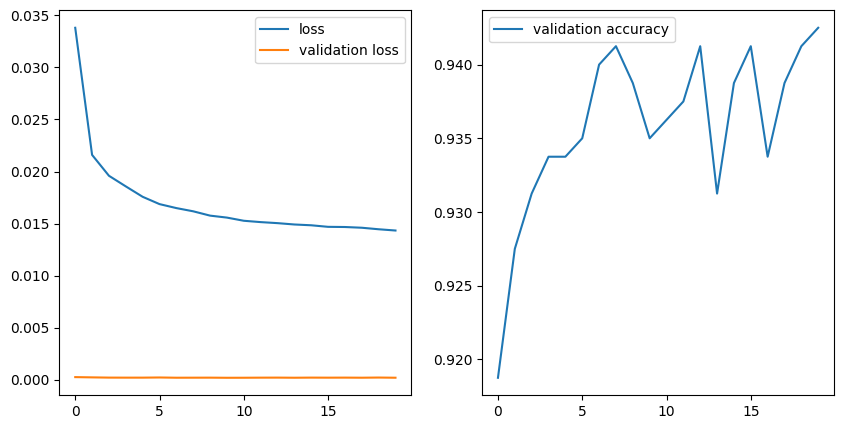

dropped: 2, test: loss: 0.14610131084918976, accuracy: 0.9487500190734863


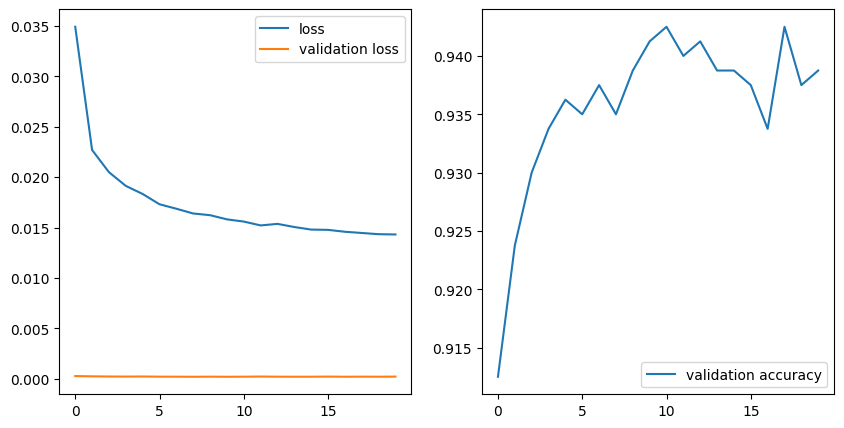

dropped: 3, test: loss: 0.14585472643375397, accuracy: 0.949999988079071


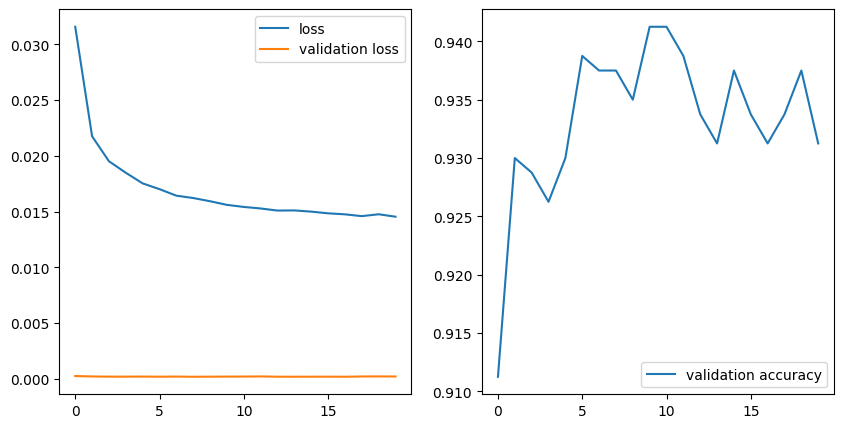

dropped: 4, test: loss: 0.1499793380498886, accuracy: 0.9454166889190674


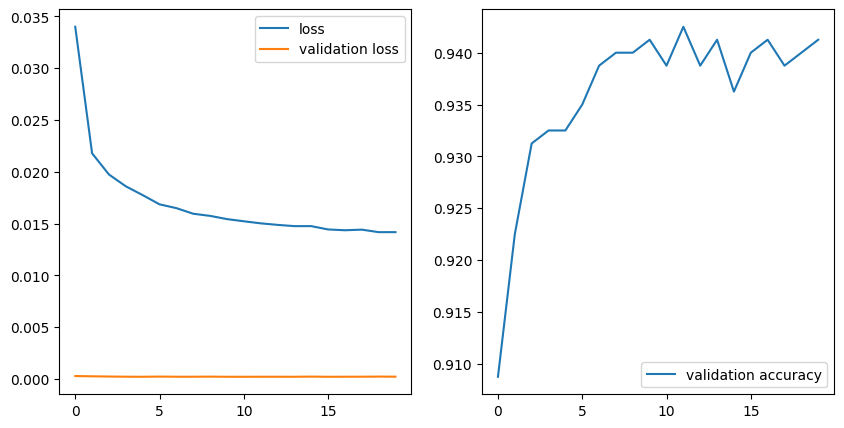

dropped: 5, test: loss: 0.14810523390769958, accuracy: 0.9483333230018616


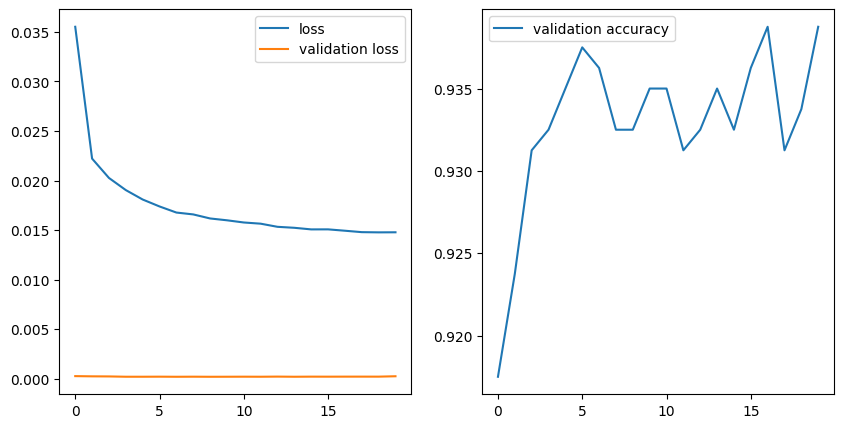

dropped: 6, test: loss: 0.16096828877925873, accuracy: 0.940416693687439


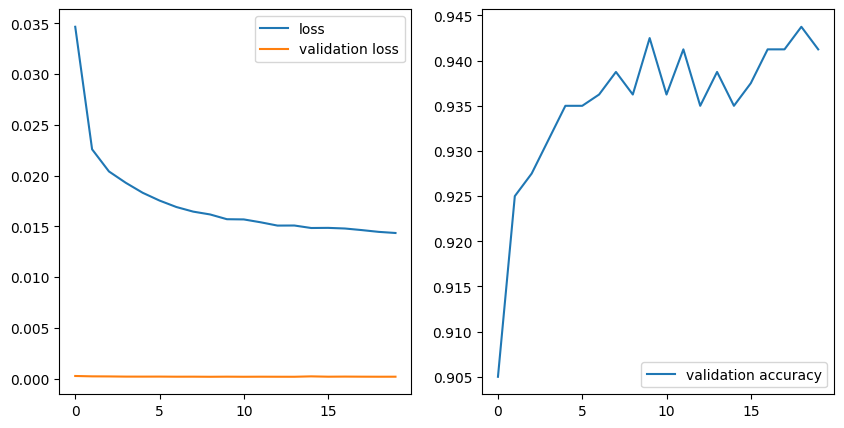

dropped: 7, test: loss: 0.14549580216407776, accuracy: 0.9512500166893005


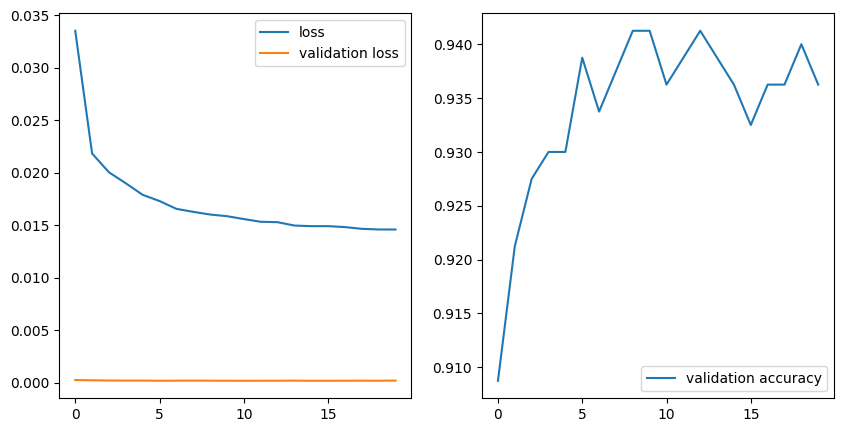

dropped: 8, test: loss: 0.15053842961788177, accuracy: 0.9474999904632568


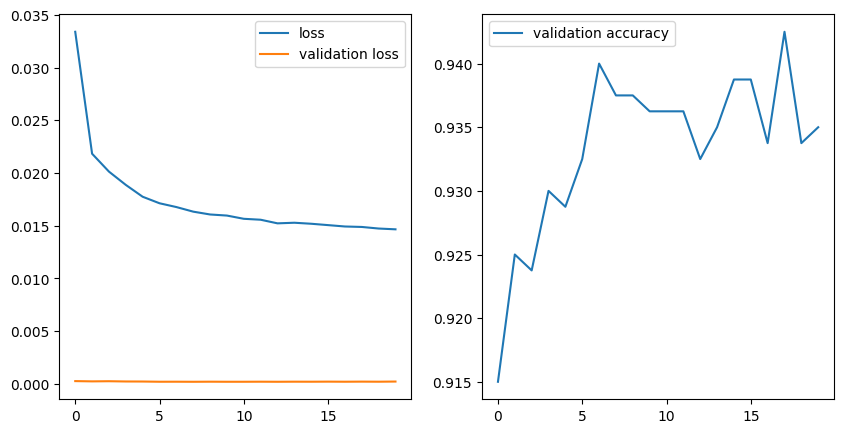

dropped: 9, test: loss: 0.14936277270317078, accuracy: 0.9470833539962769


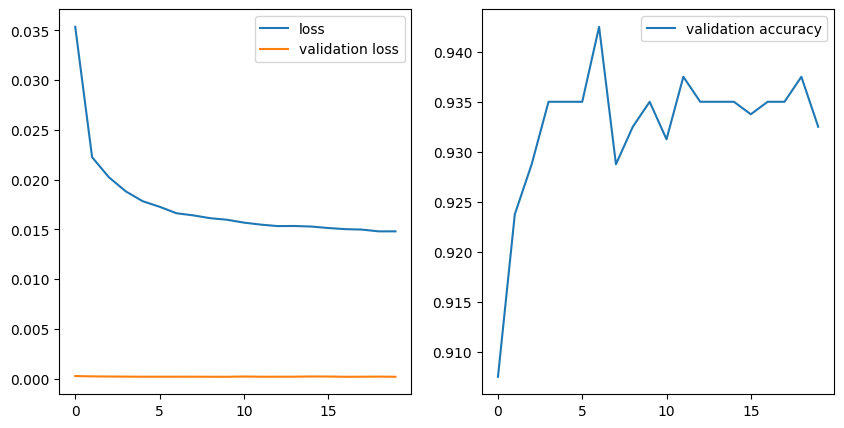

dropped: 10, test: loss: 0.1494598239660263, accuracy: 0.9483333230018616


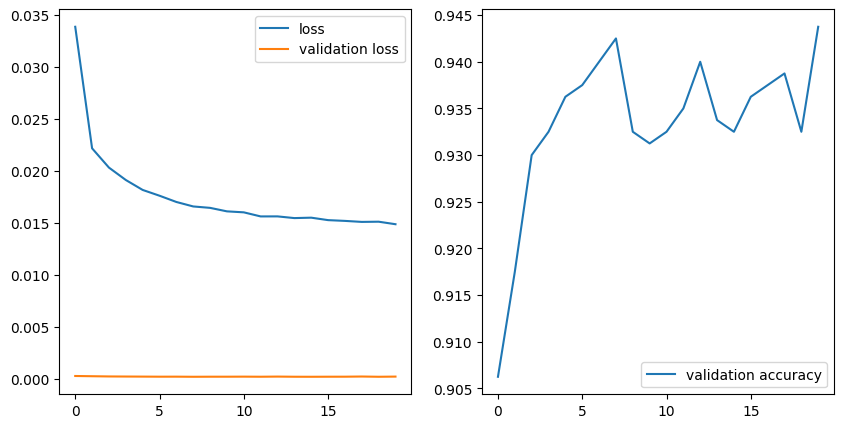

dropped: 11, test: loss: 0.15116162598133087, accuracy: 0.9441666603088379


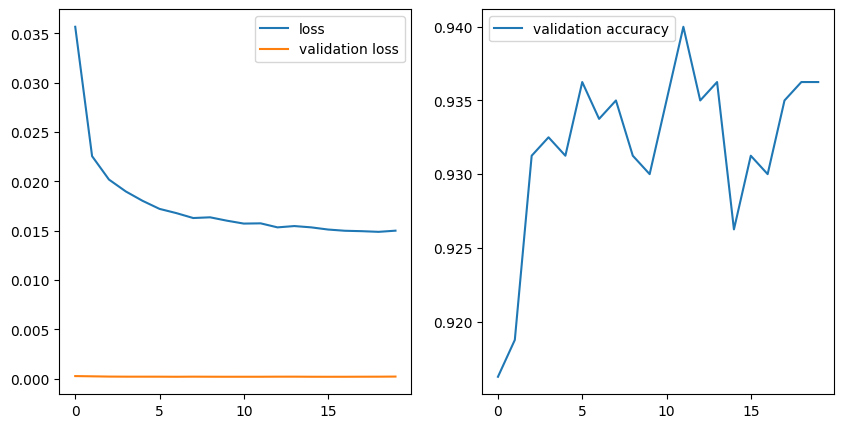

dropped: 12, test: loss: 0.14806373417377472, accuracy: 0.9429166913032532


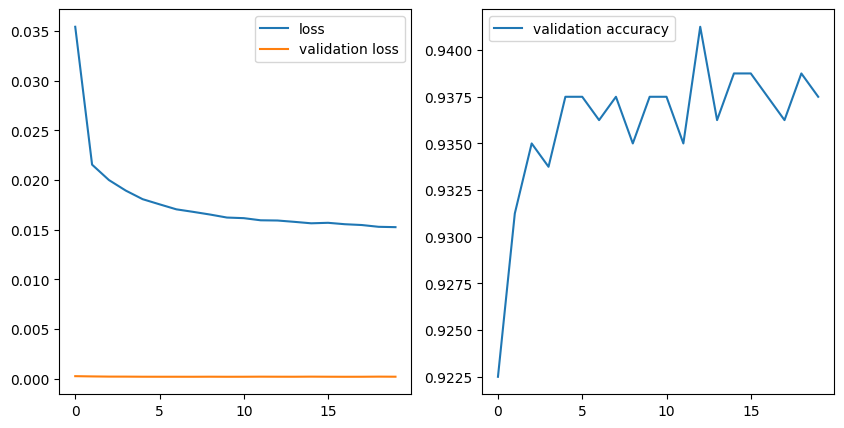

dropped: 13, test: loss: 0.15031099319458008, accuracy: 0.9454166889190674


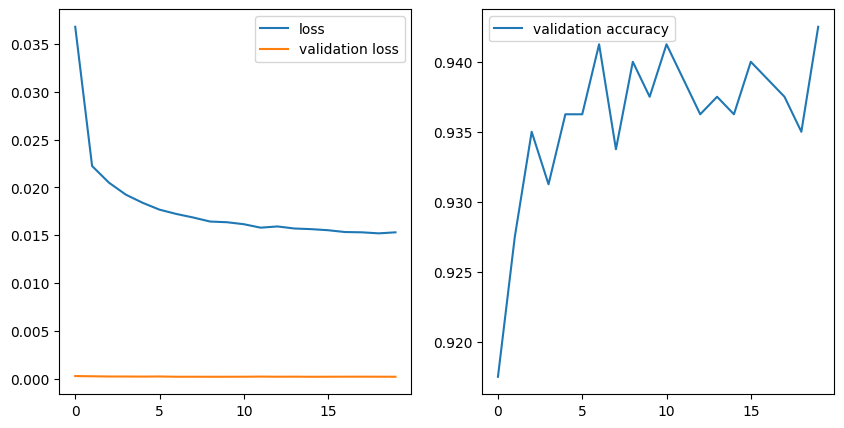

dropped: 14, test: loss: 0.14852946996688843, accuracy: 0.9487500190734863


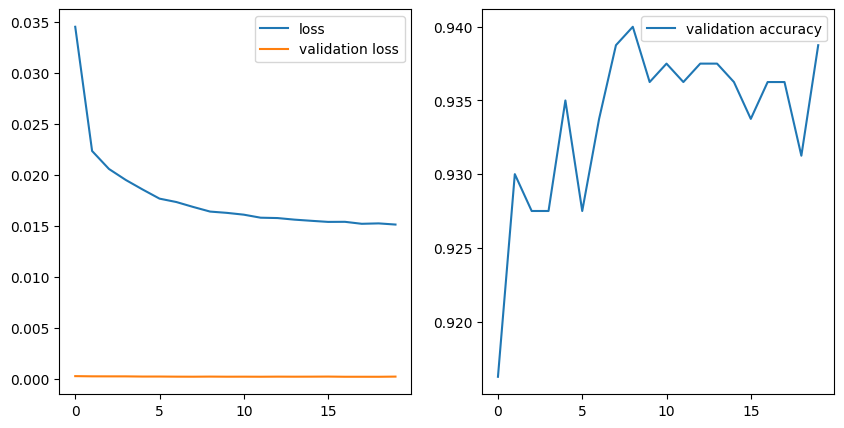

dropped: 15, test: loss: 0.14704445004463196, accuracy: 0.9474999904632568


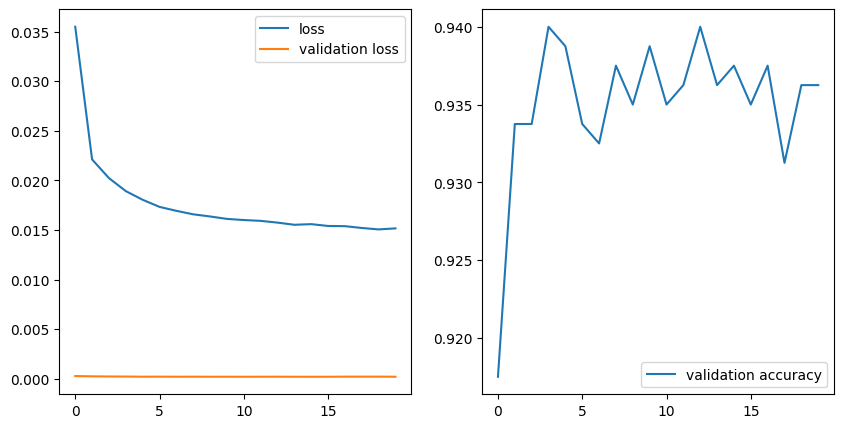

dropped: 16, test: loss: 0.14819708466529846, accuracy: 0.9474999904632568


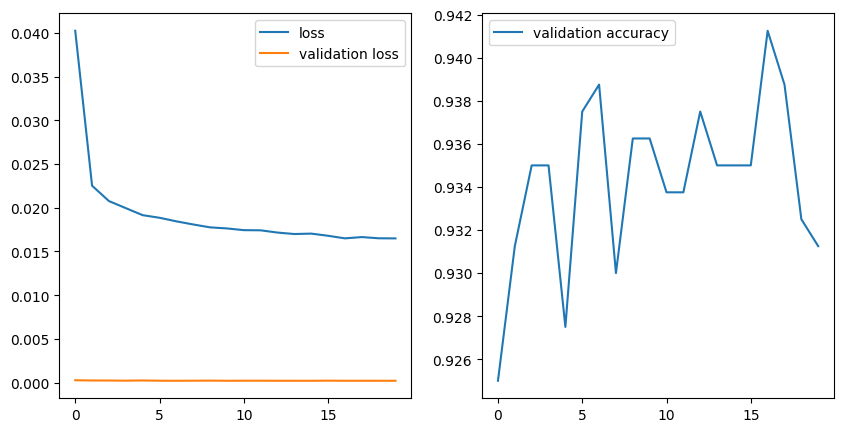

dropped: 17, test: loss: 0.1500398814678192, accuracy: 0.9441666603088379


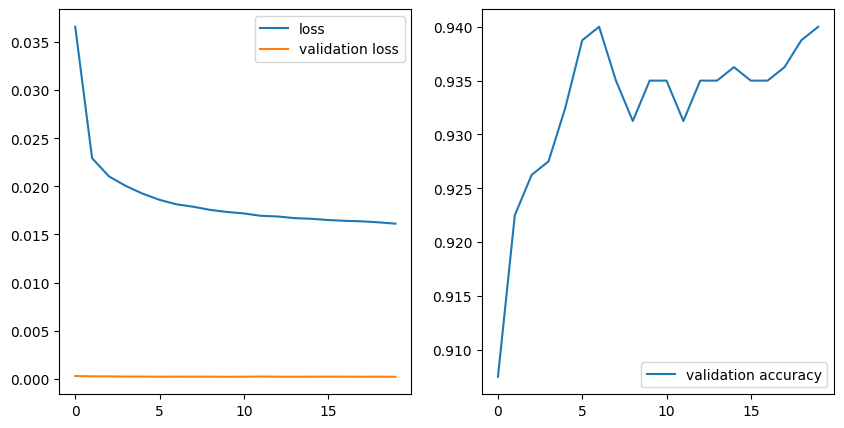

dropped: 18, test: loss: 0.15382081270217896, accuracy: 0.9454166889190674


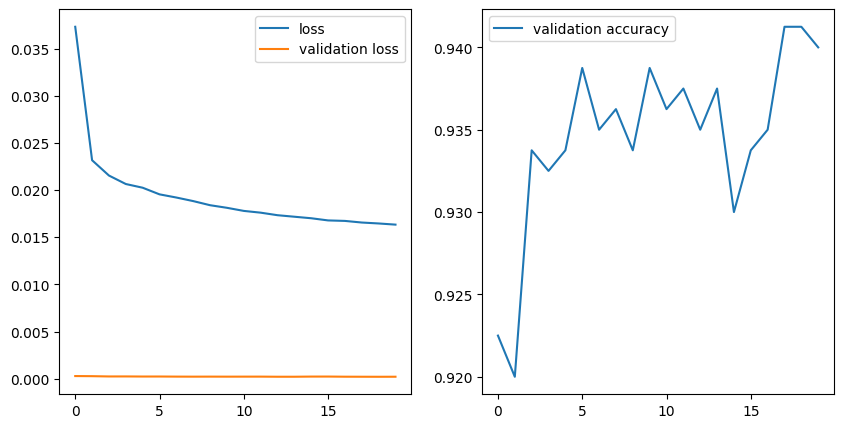

dropped: 19, test: loss: 0.15141555666923523, accuracy: 0.9462500214576721


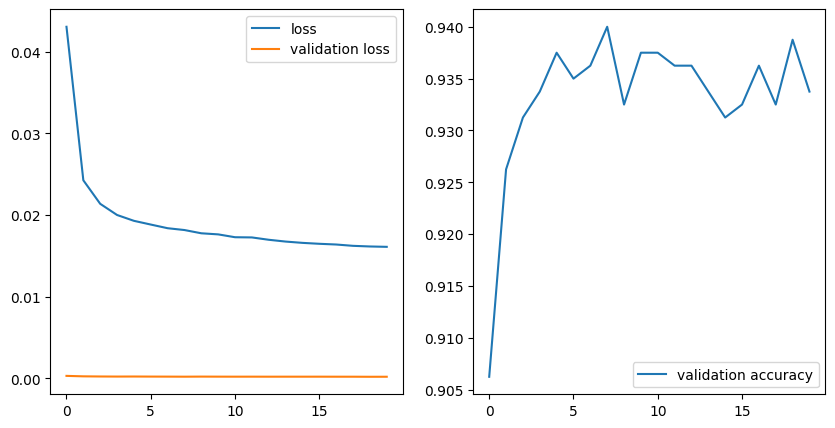

dropped: 20, test: loss: 0.1485399752855301, accuracy: 0.9441666603088379


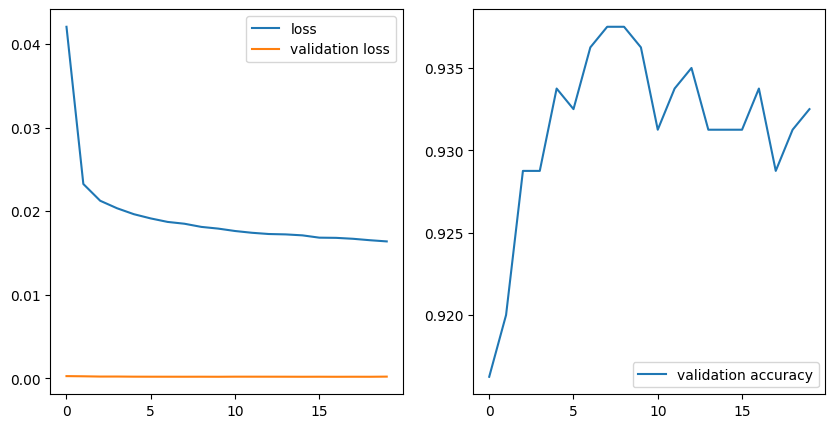

dropped: 21, test: loss: 0.1539204865694046, accuracy: 0.940416693687439


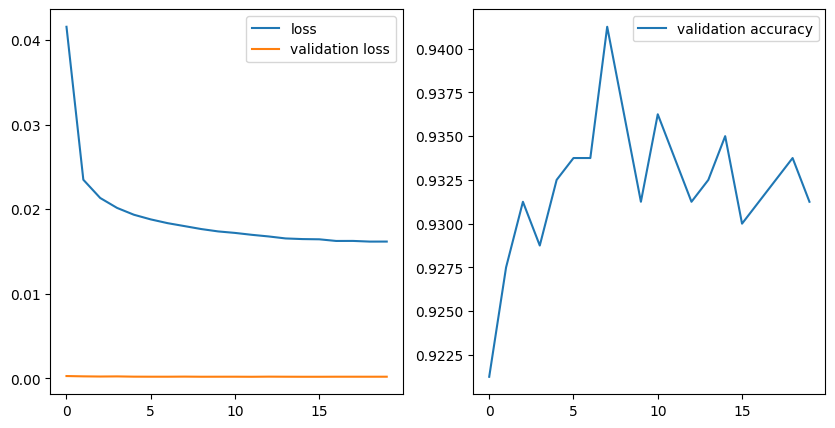

dropped: 22, test: loss: 0.1503029614686966, accuracy: 0.9462500214576721


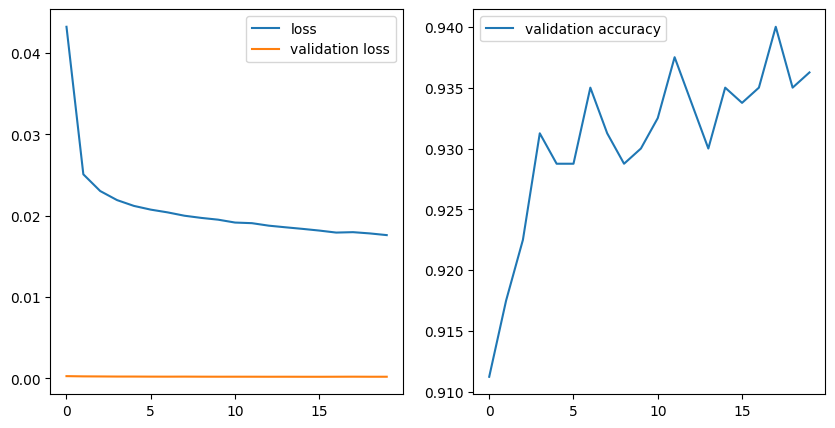

dropped: 23, test: loss: 0.15755555033683777, accuracy: 0.9420833587646484


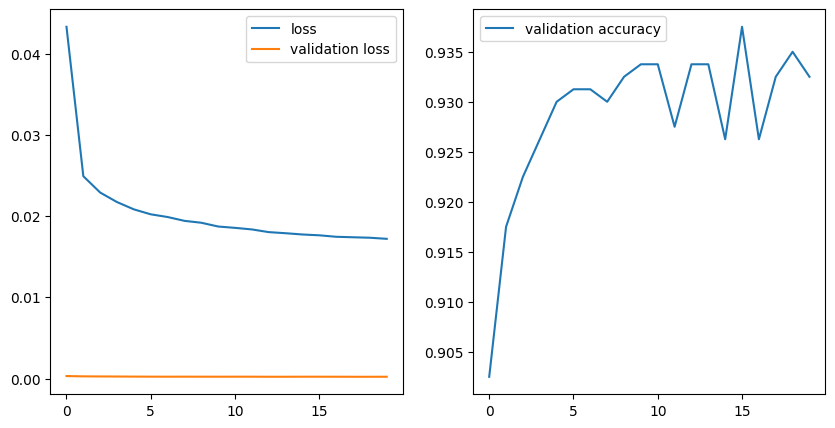

dropped: 24, test: loss: 0.16588866710662842, accuracy: 0.9395833611488342


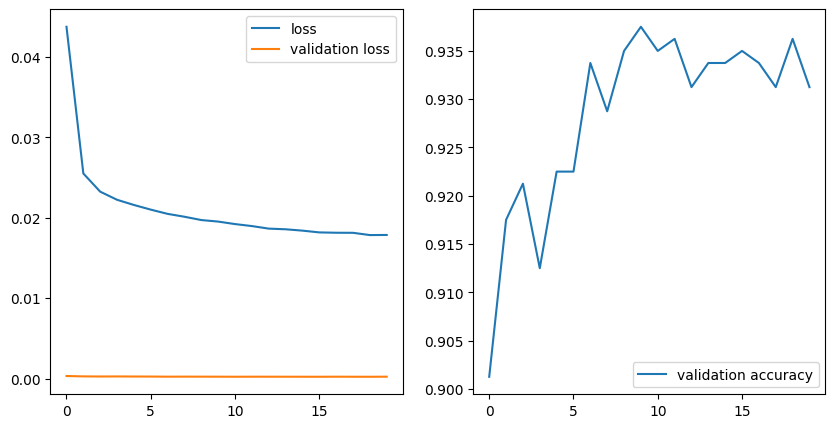

dropped: 25, test: loss: 0.16174259781837463, accuracy: 0.940416693687439


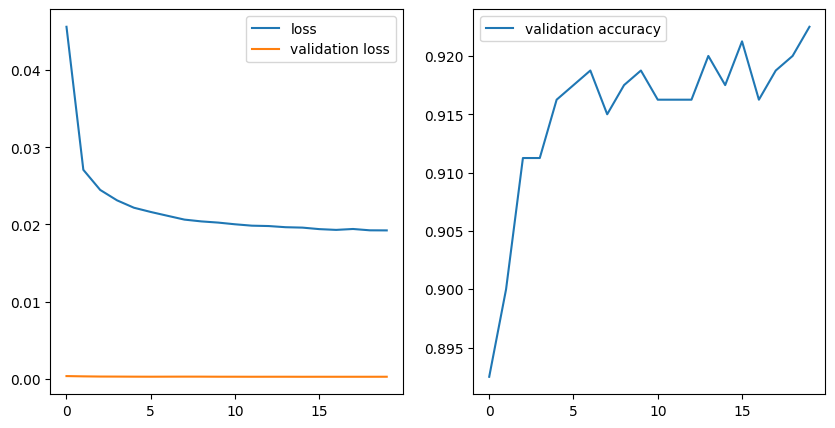

dropped: 26, test: loss: 0.16391395032405853, accuracy: 0.9370833039283752


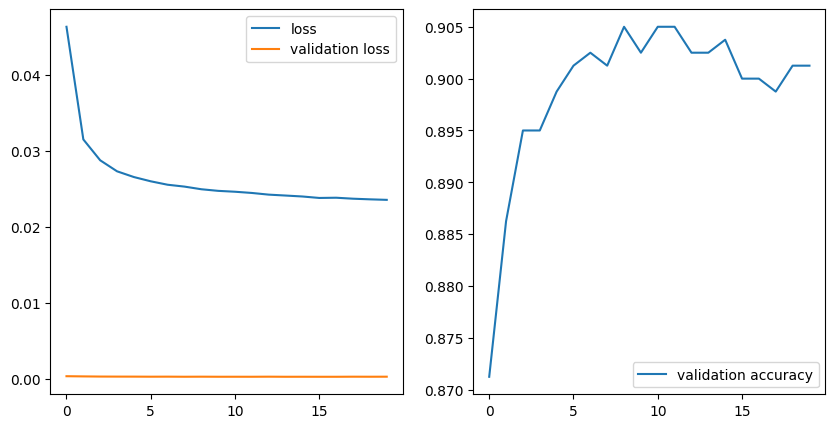

dropped: 27, test: loss: 0.20101585984230042, accuracy: 0.9275000095367432


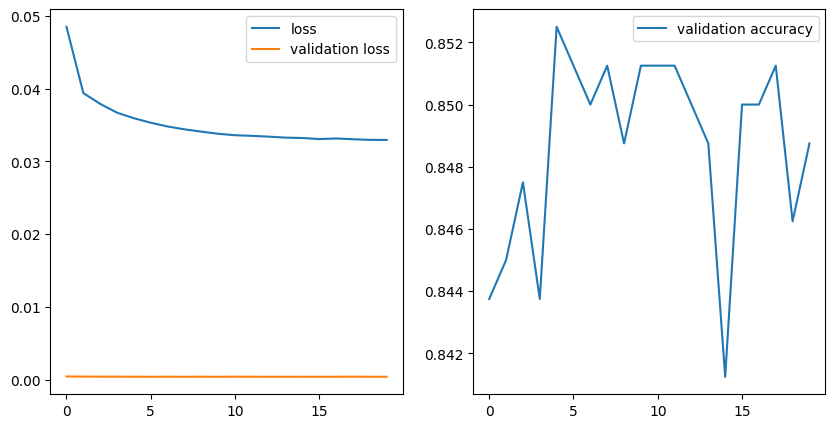

dropped: 28, test: loss: 0.27306249737739563, accuracy: 0.89083331823349


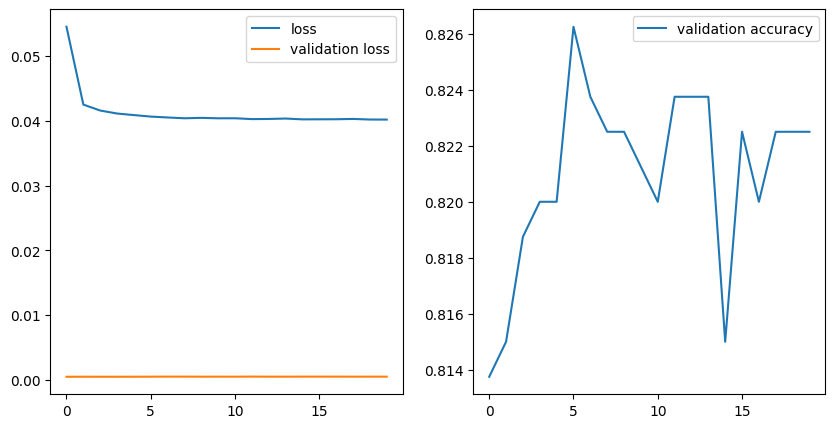

dropped: 29, test: loss: 0.34173452854156494, accuracy: 0.8604166507720947


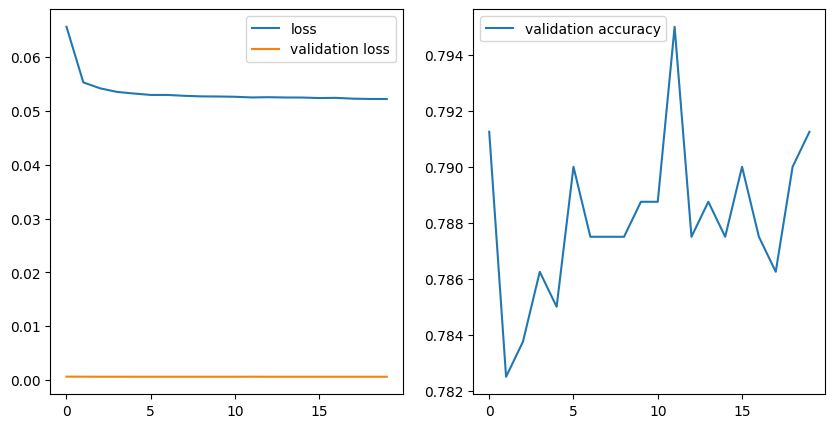

dropped: 30, test: loss: 0.4413681924343109, accuracy: 0.809583306312561


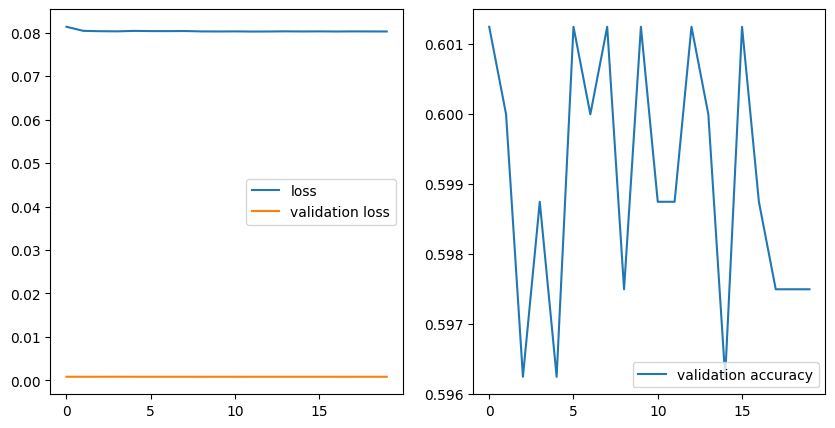

dropped: 31, test: loss: 0.6546499133110046, accuracy: 0.6025000214576721


In [39]:
# TODO: extraction to functions to accomodate other dataset+models?
hidden_size = 32
state_dict = base_model.state_dict()
criterion = nn.CrossEntropyLoss()
model_factory = lambda x, y: MLP(x, (y, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
test_accs, dropped_neurons, models = dgsm_remove_neurons(datasets, hidden_size, model_factory, optimizer_factory, criterion)

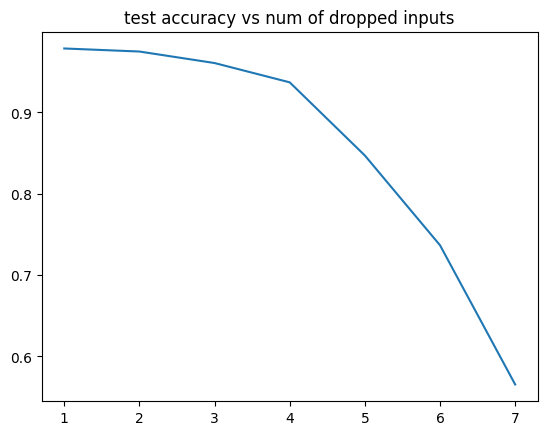

In [47]:
plt.plot(range(1, len(test_accs)+1), test_accs)
plt.title("test accuracy vs num of dropped inputs")
plt.show()

In [74]:
pick_neurons_to_drop(2, 32, dropped_neurons, best_model, models)

IndexError: index 7 is out of bounds for dimension 0 with size 7

## FAST

In [44]:
problem = analyze_fast(banana_headers)
show_stats(problem, mode = "ST")
datasets = banana_datasets.copy()
headers = banana_headers.copy()
model_factory = lambda headers : MLP(len(headers), (32, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Samples:
	7 parameters: ['Size', 'Weight', 'Sweetness', 'Softness', 'HarvestTime', 'Ripeness', 'Acidity']
	7168 samples
Outputs:
	2 outputs: ['Y1', 'Y2']
	7168 evaluations
Analysis:
Y1:
                   S1        ST   S1_conf   ST_conf
Size         0.029579  0.064973  0.016343  0.041442
Weight       0.174058  0.321964  0.017080  0.035650
Sweetness    0.020489  0.199142  0.014888  0.043075
Softness     0.000490  0.266494  0.016624  0.037275
HarvestTime  0.154897  0.287999  0.015604  0.040574
Ripeness     0.020923  0.104140  0.016183  0.040138
Acidity      0.027568  0.253277  0.016905  0.043827:
Y2:
                   S1        ST   S1_conf   ST_conf
Size         0.025547  0.060114  0.013949  0.036353
Weight       0.157788  0.303482  0.016429  0.037147
Sweetness    0.016988  0.197196  0.014404  0.040007
Softness     0.002199  0.268986  0.016451  0.038433
HarvestTime  0.168579  0.307650  0.014222  0.034565
Ripeness     0.022917  0.105045  0.012508  0.039144
Acidity      0.019542  0.2539

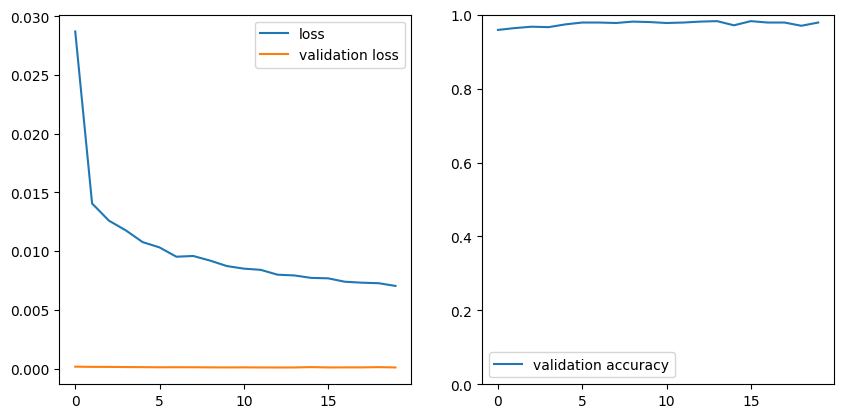

Test: loss: 0.07863813638687134, accuracy: 0.9787499904632568
dropping feature: (0, 'Size')


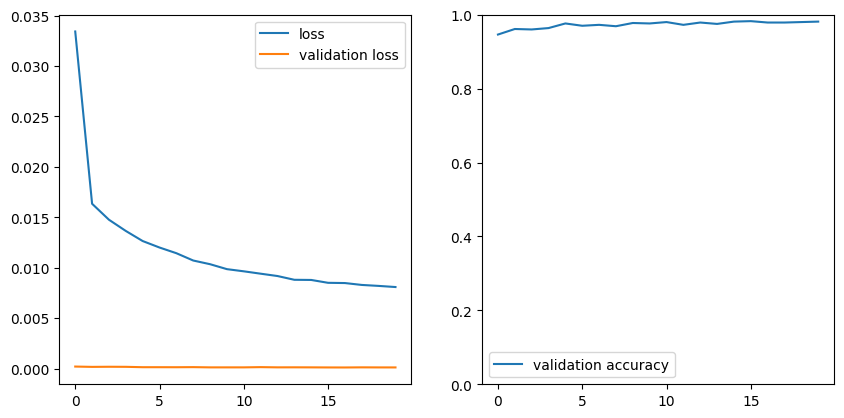

Test: loss: 0.0904255360364914, accuracy: 0.9750000238418579
dropping feature: (1, 'Sweetness')


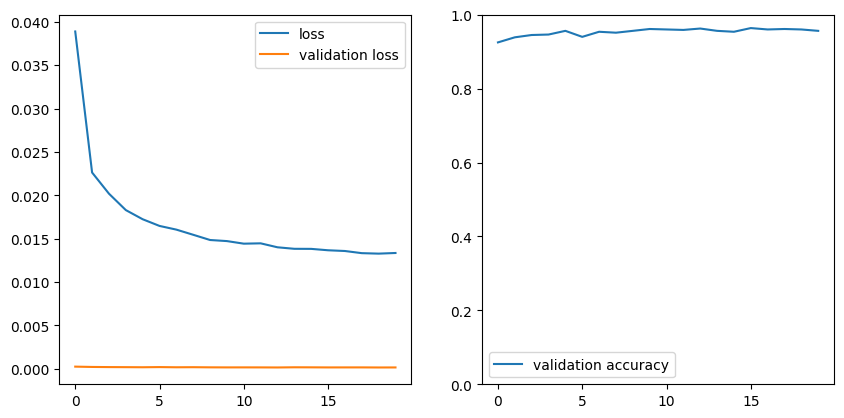

Test: loss: 0.12054407596588135, accuracy: 0.9608333110809326
dropping feature: (3, 'Ripeness')


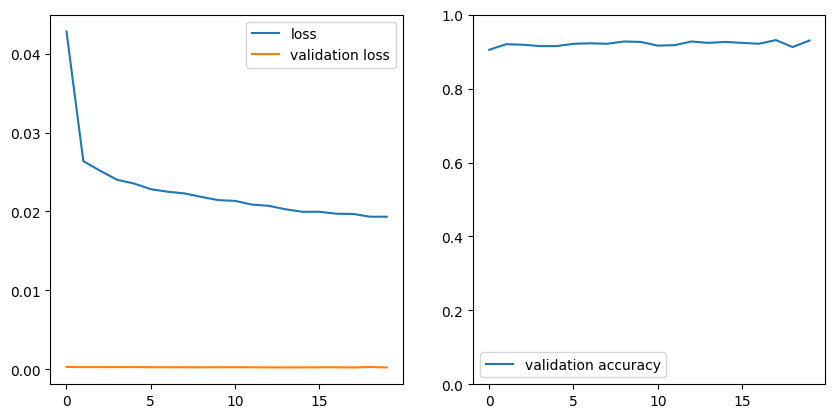

Test: loss: 0.16499024629592896, accuracy: 0.9370833039283752
dropping feature: (1, 'Softness')


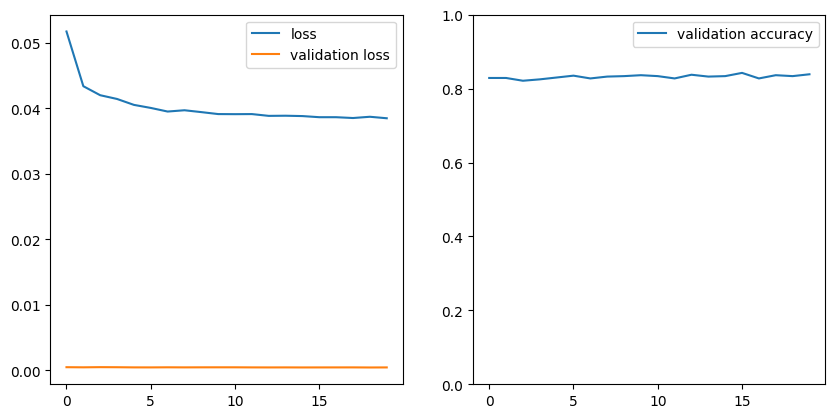

Test: loss: 0.329475075006485, accuracy: 0.847083330154419
dropping feature: (1, 'HarvestTime')


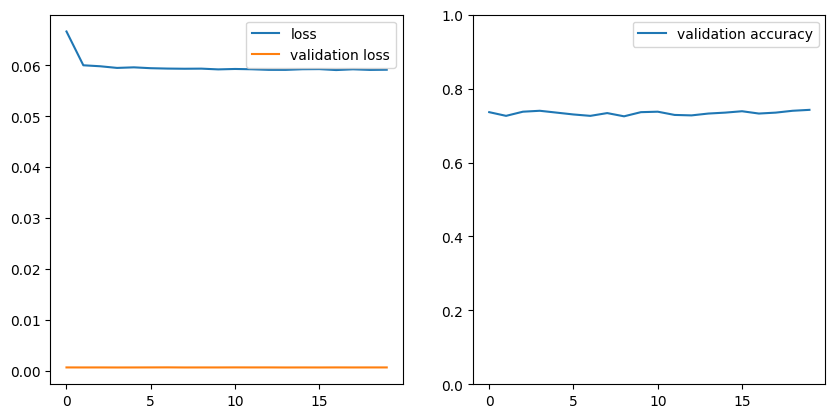

Test: loss: 0.4790259301662445, accuracy: 0.7366666793823242
dropping feature: (0, 'Weight')


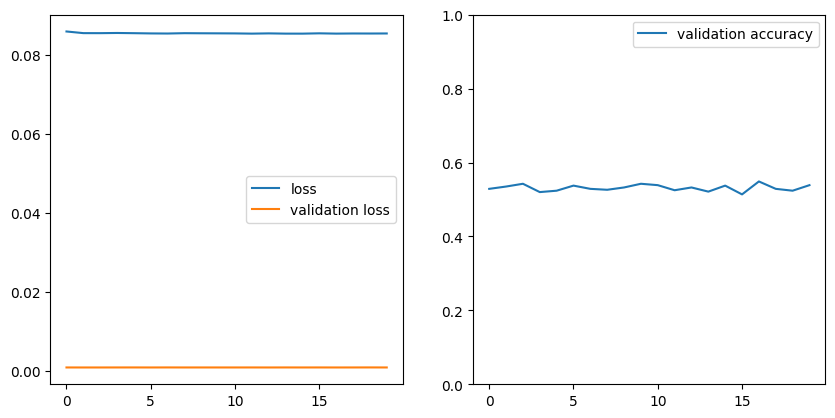

Test: loss: 0.6808589696884155, accuracy: 0.565416693687439


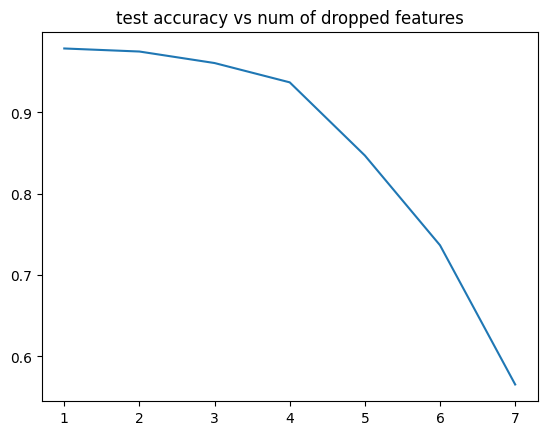

In [45]:
test_accs, dropped_headers, models = fast_remove_headers(datasets, headers, model_factory, optimizer_factory ,criterion)
plt.plot(range(1, len(test_accs)+1), test_accs)
plt.title("test accuracy vs num of dropped features")
plt.show()

In [ ]:
reduced_headers = banana_headers.copy()
datasets = banana_datasets
num_drop_features = 21
best_model, reduced_datasets = pick_features_to_drop(reduced_headers, dropped_headers, models, datasets, num_drop_features)

[9] features left: ['radius1', 'texture1', 'area2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'concavity3']


In [ ]:
layer: nn.Module = best_model.layer1
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

In [ ]:
# not needed in this model, maybe usefull in bigger one to save some traning time? to be tested
# will need acrobatics for sure (tweaking state_dict)
base_model = MLP(len(banana_headers), (32, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_pre_train(base_model, criterion, optimizer_factory, datasets)

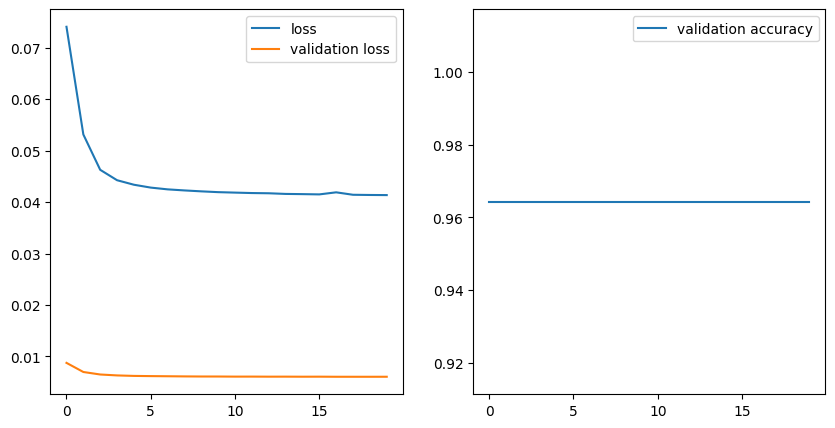

dropped: 0, test: loss: 0.3366217613220215, accuracy: 0.9825581312179565


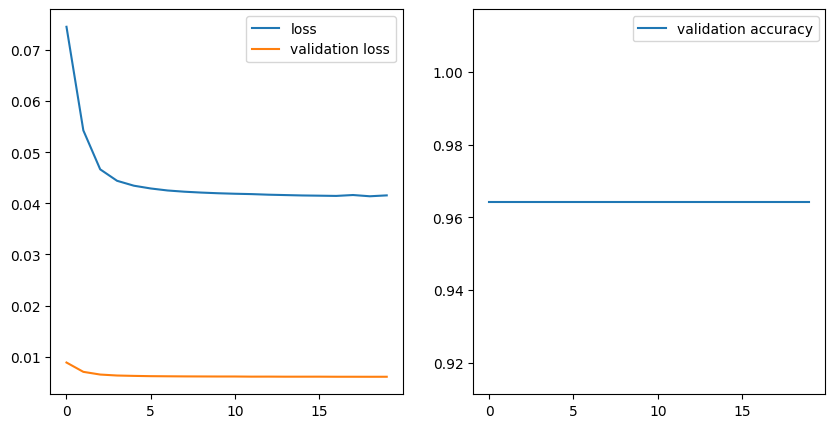

dropped: 1, test: loss: 0.3363381624221802, accuracy: 0.9825581312179565


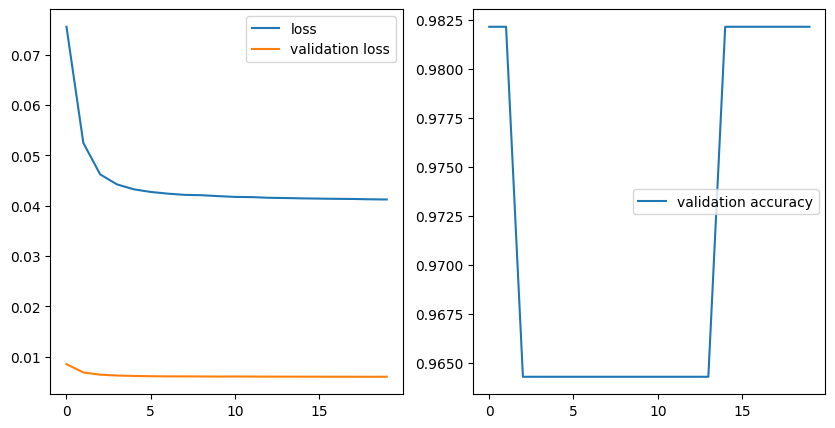

dropped: 2, test: loss: 0.33540070056915283, accuracy: 0.9825581312179565


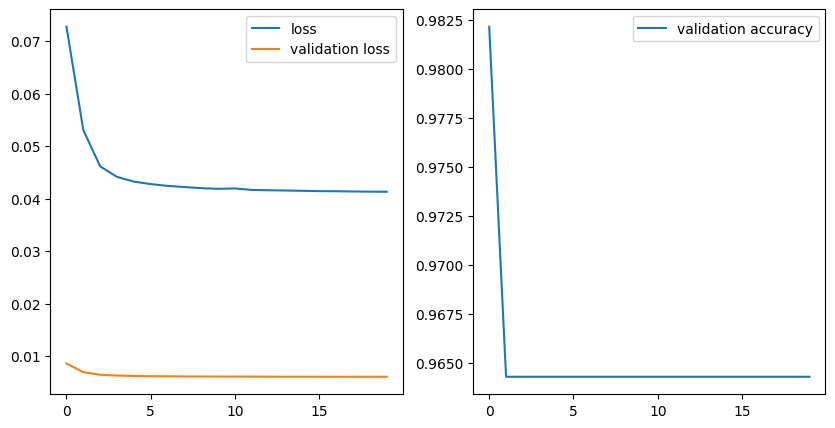

dropped: 3, test: loss: 0.33557364344596863, accuracy: 0.9825581312179565


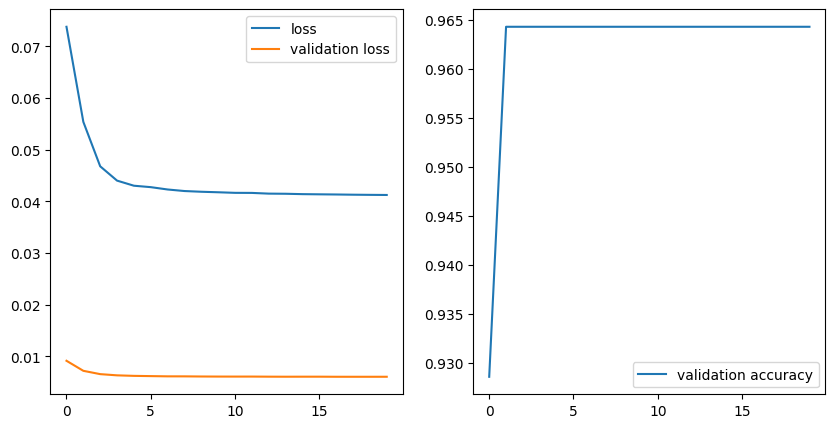

dropped: 4, test: loss: 0.33577975630760193, accuracy: 0.9825581312179565


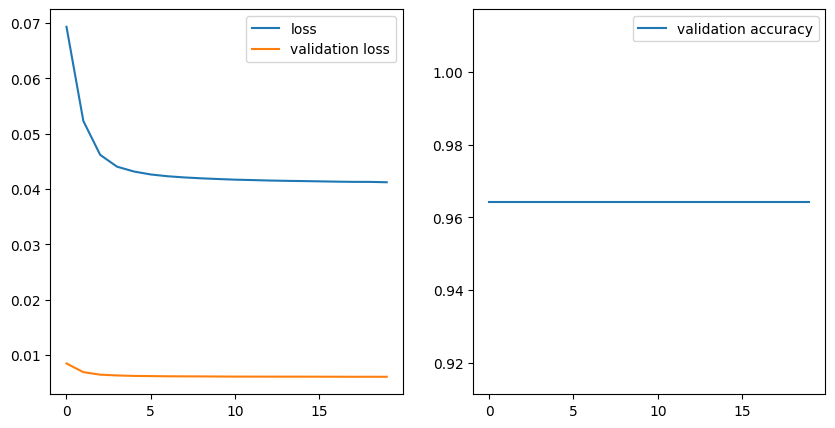

dropped: 5, test: loss: 0.3348945677280426, accuracy: 0.9825581312179565


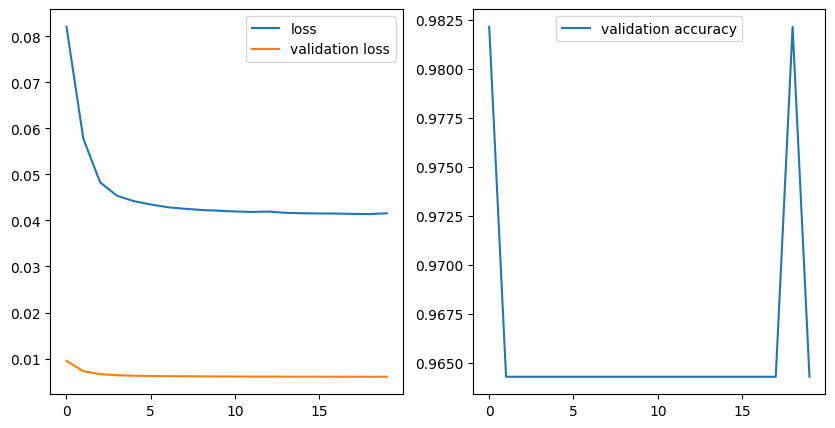

dropped: 6, test: loss: 0.33600255846977234, accuracy: 0.9825581312179565


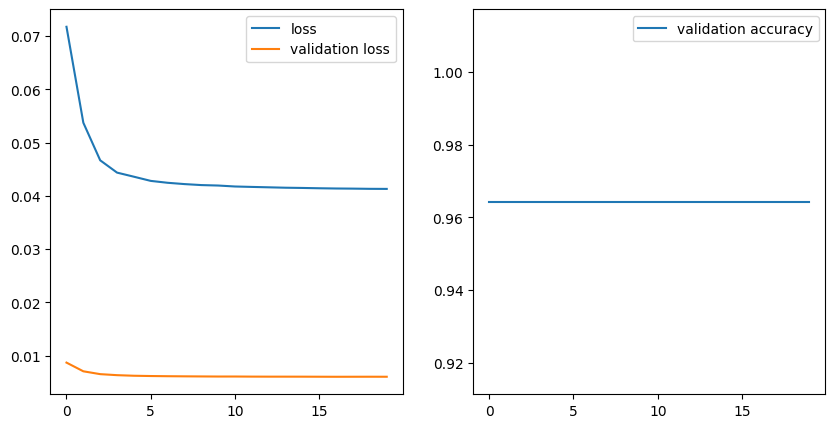

dropped: 7, test: loss: 0.3355944752693176, accuracy: 0.9825581312179565


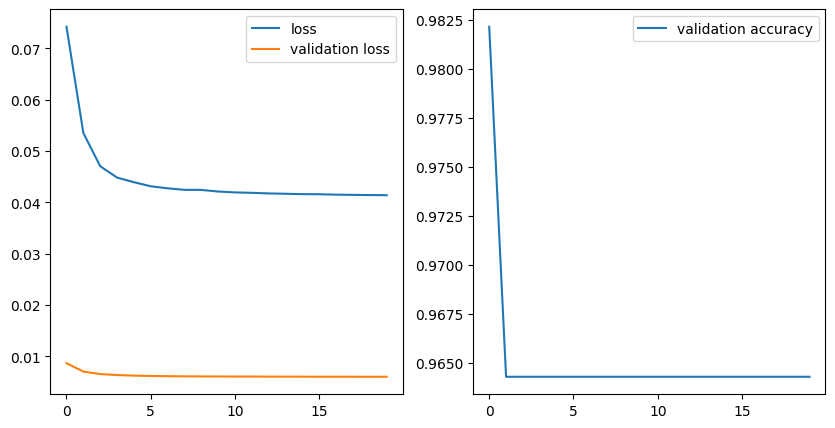

dropped: 8, test: loss: 0.33590638637542725, accuracy: 0.9825581312179565


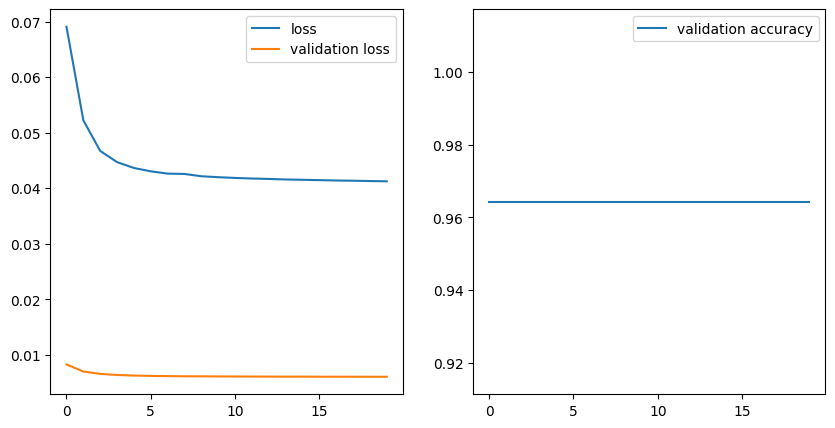

dropped: 9, test: loss: 0.3355138599872589, accuracy: 0.9825581312179565


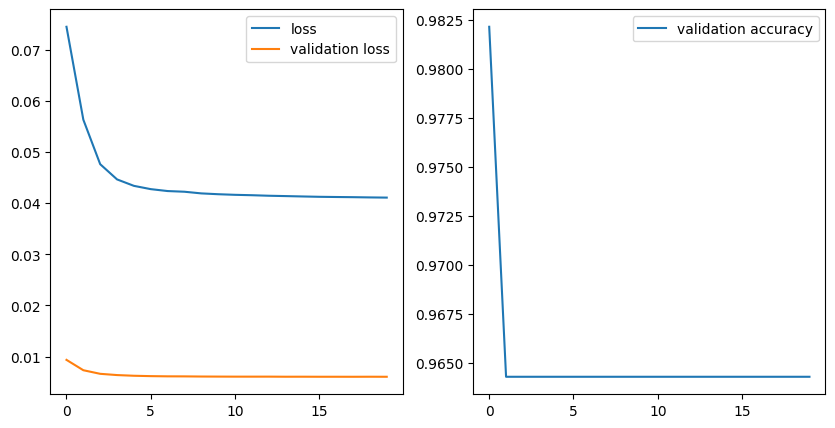

dropped: 10, test: loss: 0.33475369215011597, accuracy: 0.9825581312179565


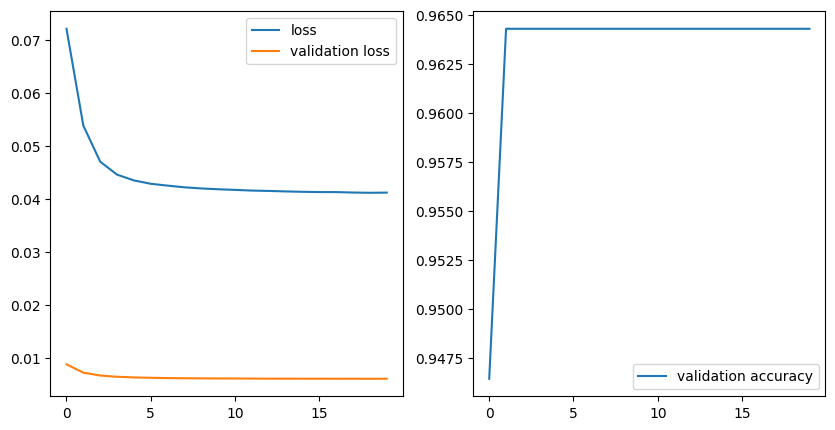

dropped: 11, test: loss: 0.3349631428718567, accuracy: 0.9825581312179565


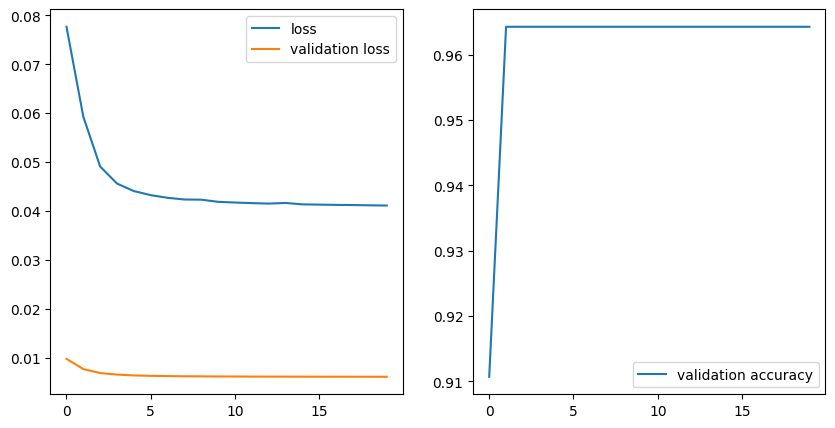

dropped: 12, test: loss: 0.3348318636417389, accuracy: 0.9825581312179565


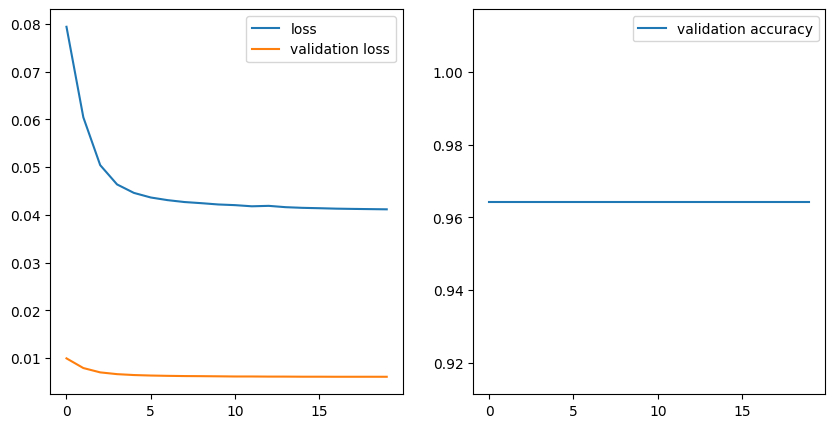

dropped: 13, test: loss: 0.33533814549446106, accuracy: 0.9825581312179565


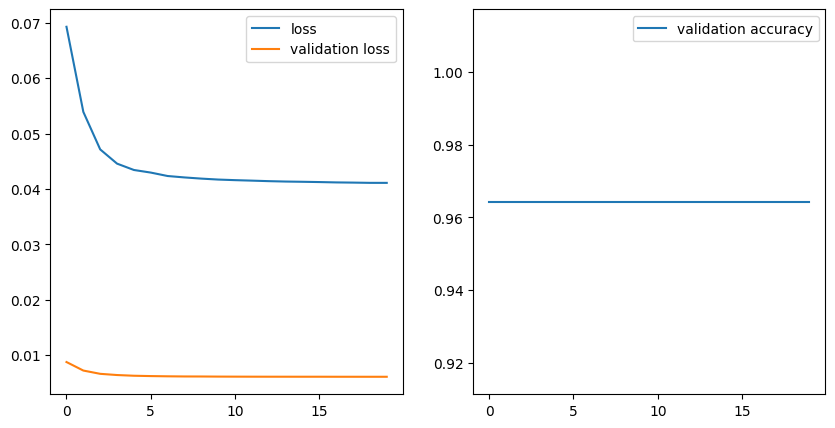

dropped: 14, test: loss: 0.334490567445755, accuracy: 0.9825581312179565


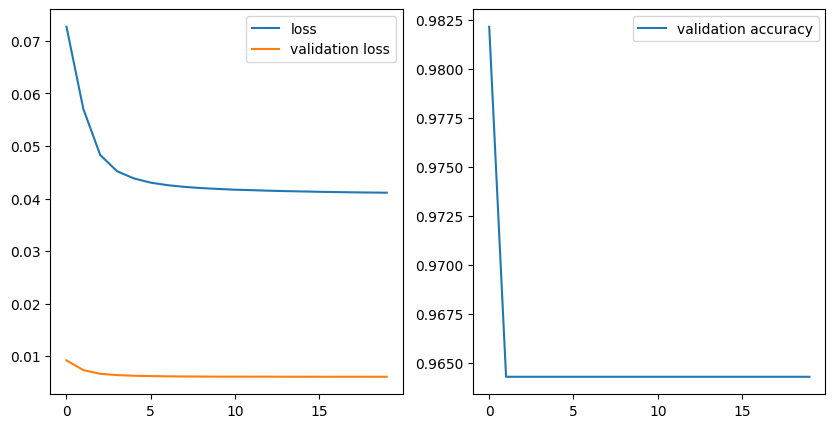

dropped: 15, test: loss: 0.334784597158432, accuracy: 0.9825581312179565


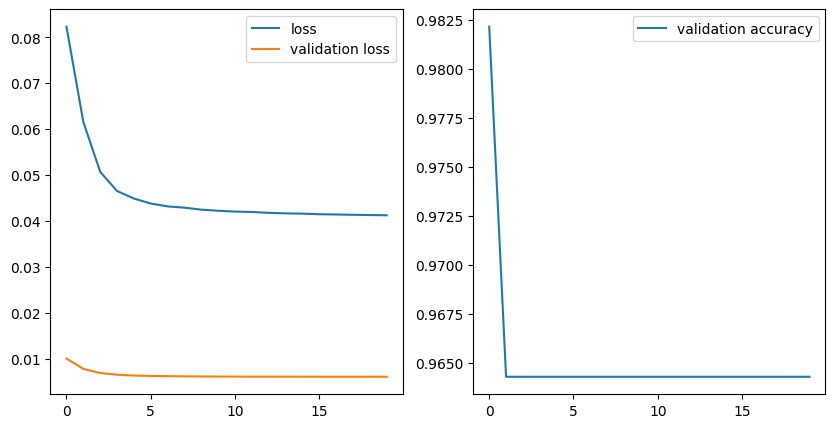

dropped: 16, test: loss: 0.3354591131210327, accuracy: 0.9825581312179565


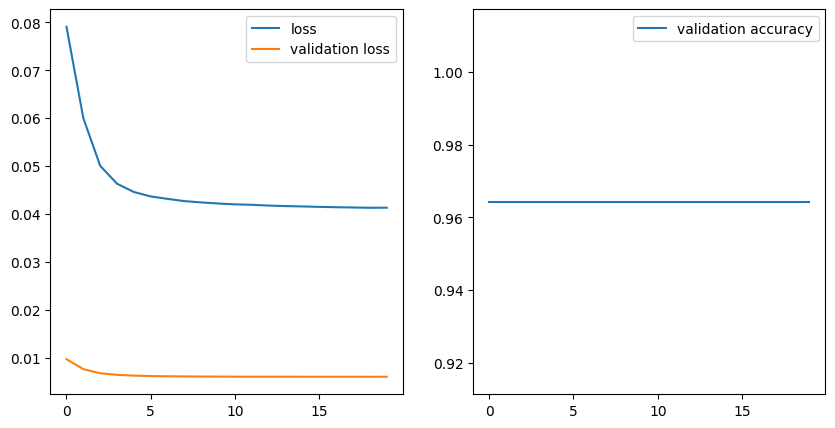

dropped: 17, test: loss: 0.3359697163105011, accuracy: 0.9825581312179565


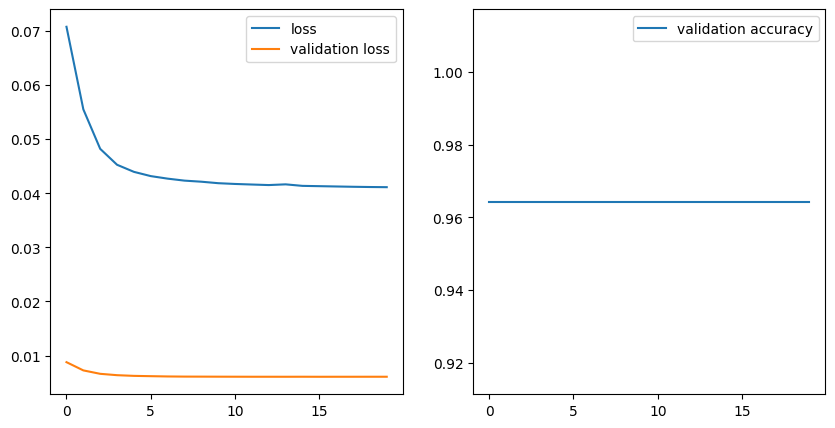

dropped: 18, test: loss: 0.33526816964149475, accuracy: 0.9825581312179565


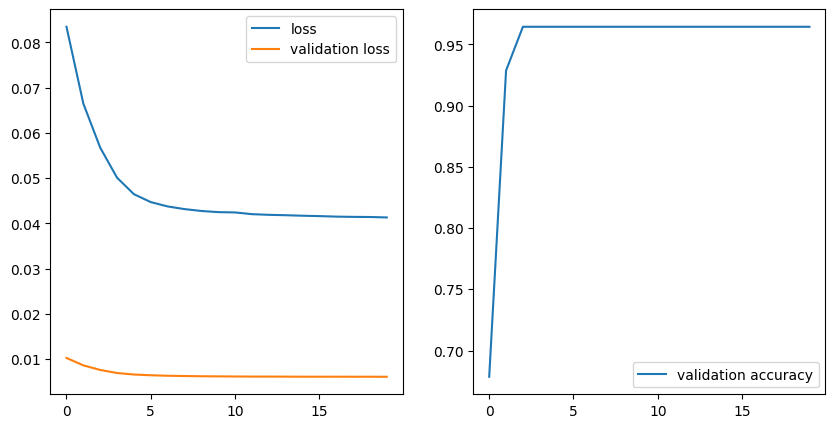

dropped: 19, test: loss: 0.3364447355270386, accuracy: 0.9825581312179565


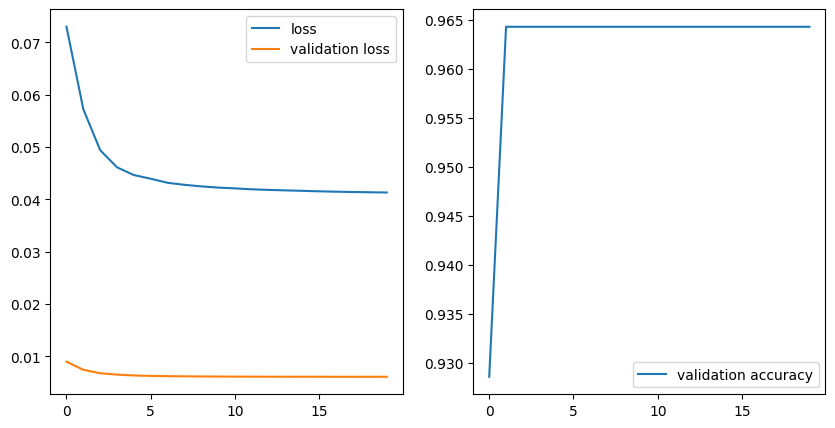

dropped: 20, test: loss: 0.3360954523086548, accuracy: 0.9825581312179565


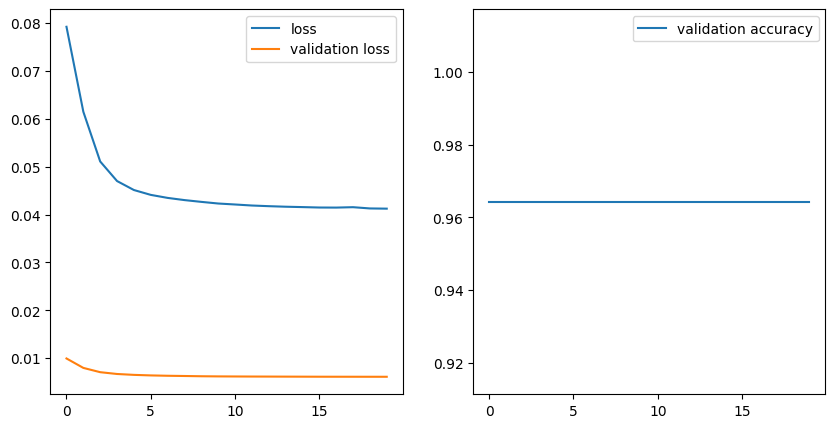

dropped: 21, test: loss: 0.3360651135444641, accuracy: 0.9825581312179565


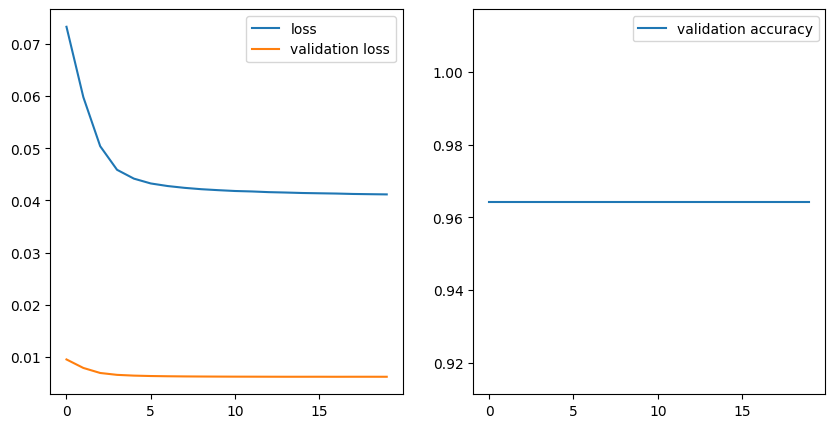

dropped: 22, test: loss: 0.3353289067745209, accuracy: 0.9825581312179565


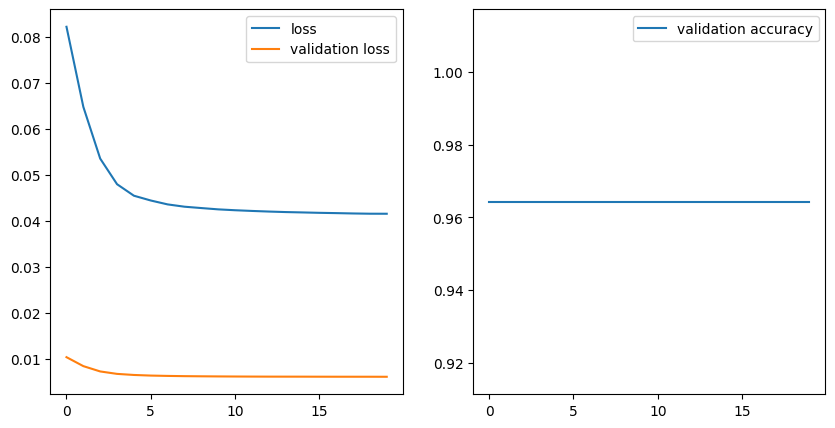

dropped: 23, test: loss: 0.3367639482021332, accuracy: 0.9825581312179565


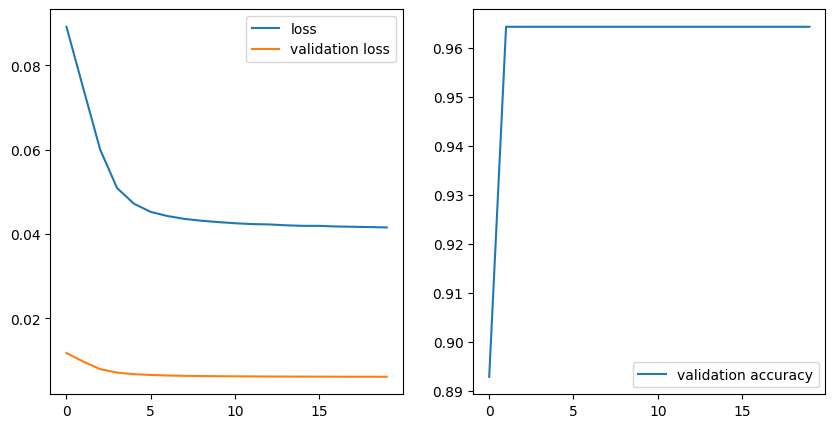

dropped: 24, test: loss: 0.33744359016418457, accuracy: 0.9825581312179565


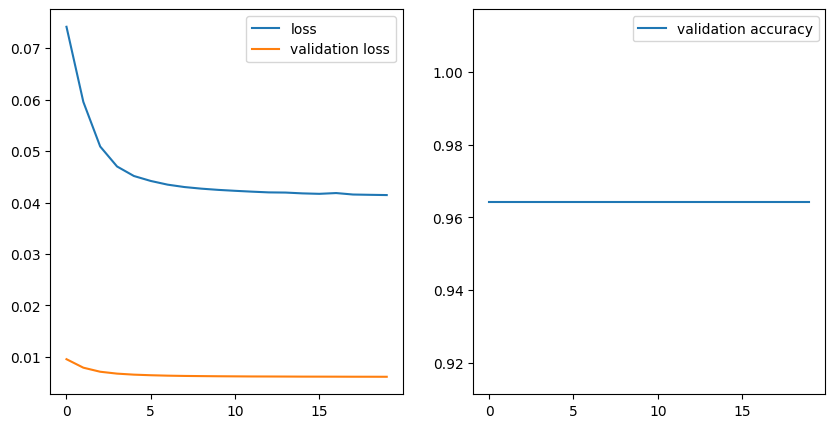

dropped: 25, test: loss: 0.33774712681770325, accuracy: 0.9825581312179565


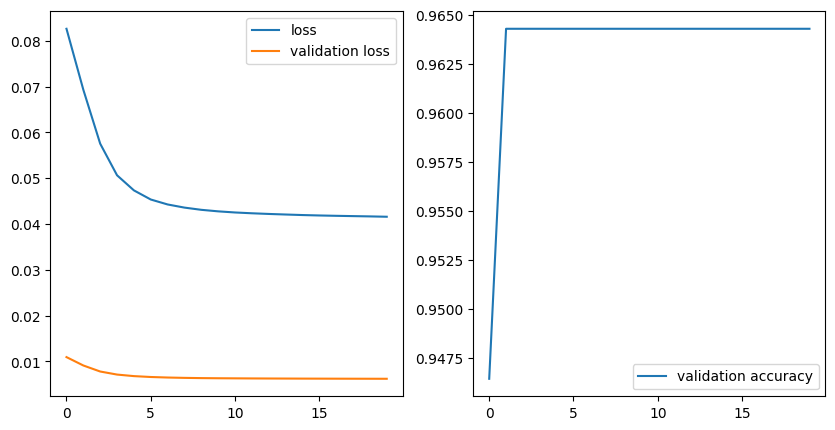

dropped: 26, test: loss: 0.3399074375629425, accuracy: 0.9709302186965942


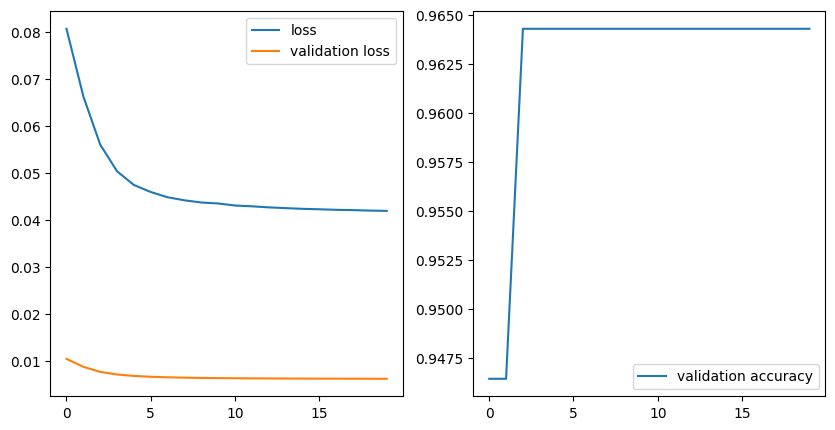

dropped: 27, test: loss: 0.3414041996002197, accuracy: 0.9767441749572754


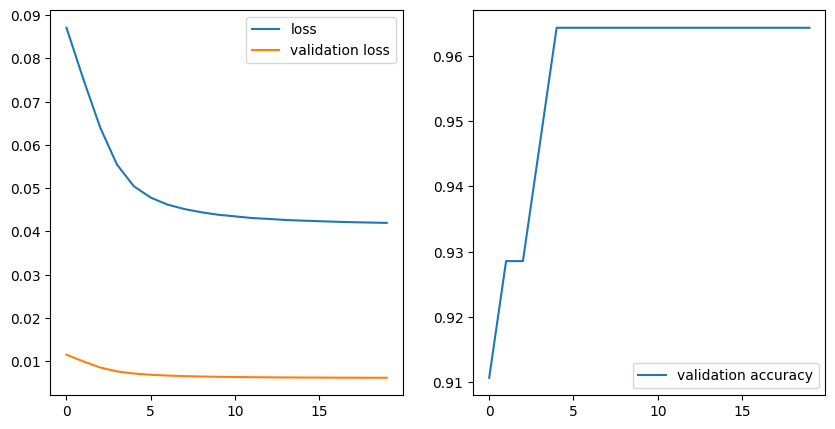

dropped: 28, test: loss: 0.3433670997619629, accuracy: 0.9767441749572754


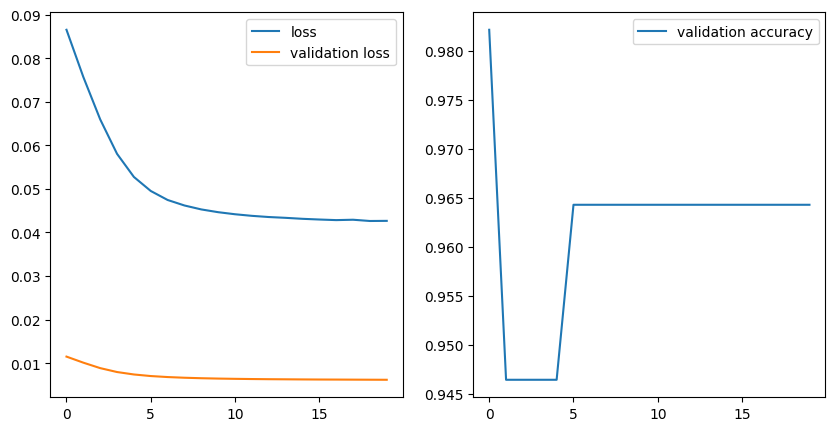

dropped: 29, test: loss: 0.3431805968284607, accuracy: 0.9825581312179565


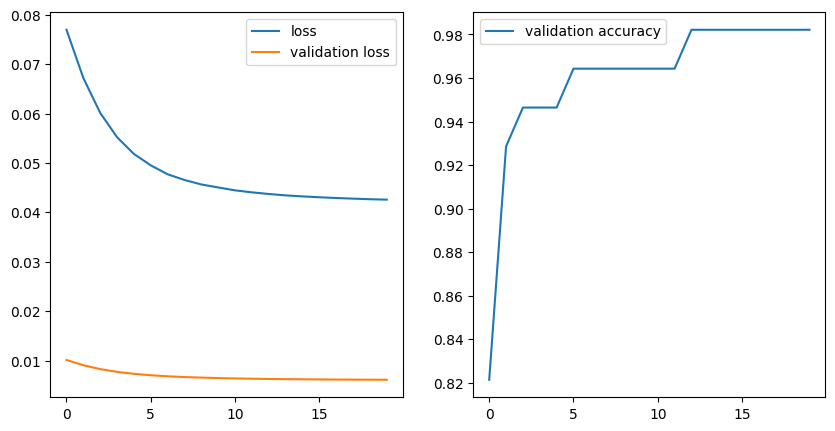

dropped: 30, test: loss: 0.3449694514274597, accuracy: 0.9825581312179565


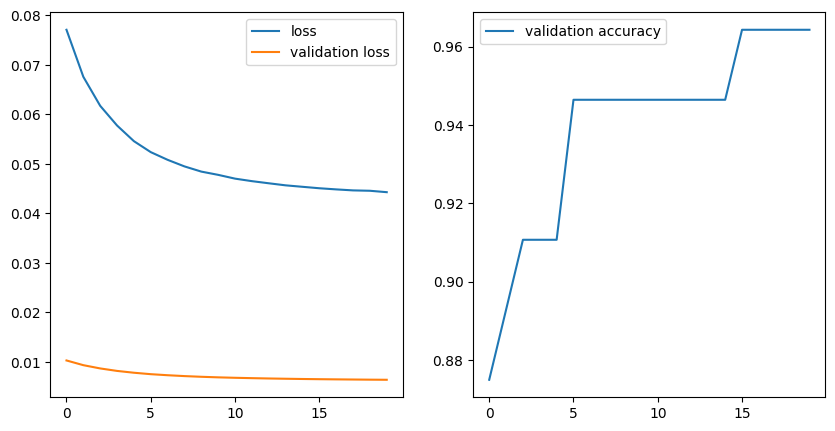

dropped: 31, test: loss: 0.35561224818229675, accuracy: 0.9593023061752319


In [ ]:
# Layer 1
hidden_size = 32
state_dict = base_model.state_dict()
criterion = nn.CrossEntropyLoss()
model_factory = lambda x, y: MLP(x, (y, 32), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
test_accs, dropped_neurons, models = fast_remove_neurons(datasets, hidden_size, model_factory, optimizer_factory, criterion)

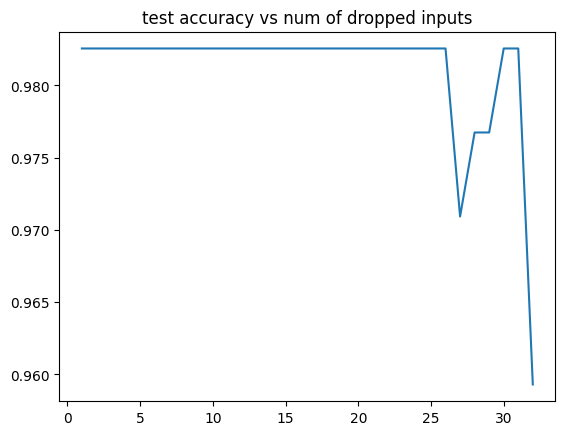

In [ ]:
plt.plot(range(1, len(test_accs)+1), test_accs)
plt.title("test accuracy vs num of dropped inputs")
plt.show()

In [ ]:
num_drop_neurons = 28
best_model_layer1, reduced_datasets_neurons_layer1 = pick_neurons_to_drop(num_drop_neurons, hidden_size, dropped_neurons, best_model, models)

In [ ]:
print(best_model_layer1)

BreastCancerNN(
  (layer1): Sequential(
    (0): Linear(in_features=9, out_features=4, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=32, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)


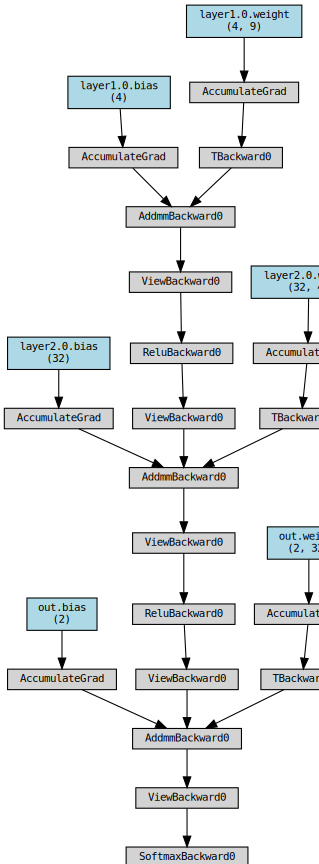

In [ ]:
y = best_model_layer1(reduced_datasets["test"][0][0]);
make_dot(y.mean(), params=dict(best_model_layer1.named_parameters()))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


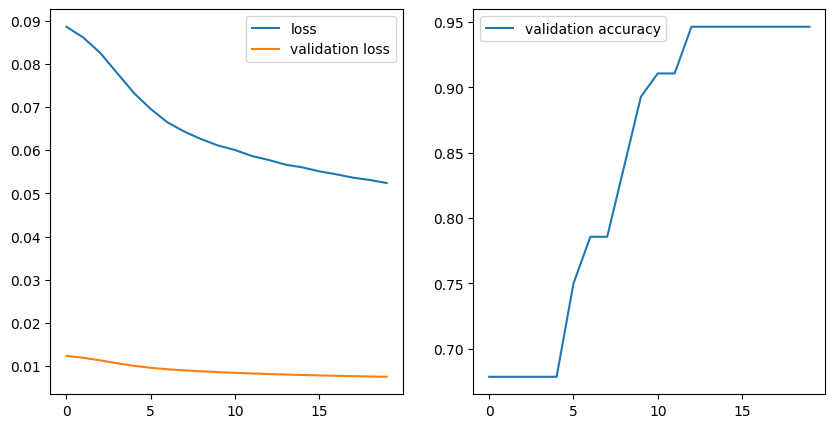

dropped: 0, test: loss: 0.42741402983665466, accuracy: 0.9534883499145508


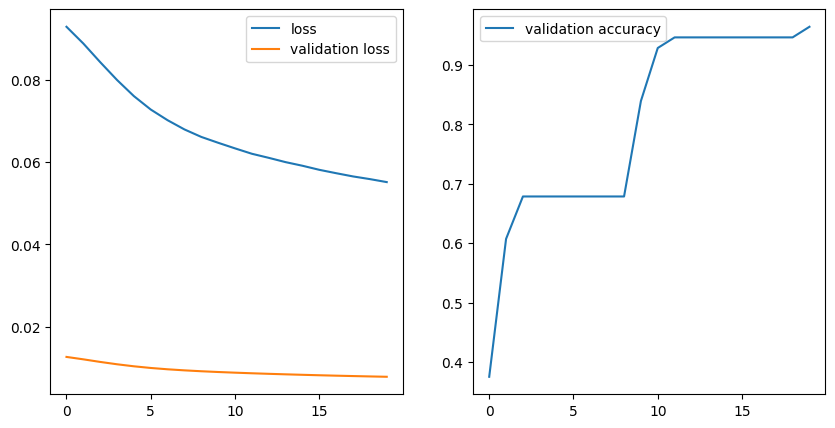

dropped: 1, test: loss: 0.4484131932258606, accuracy: 0.9593023061752319


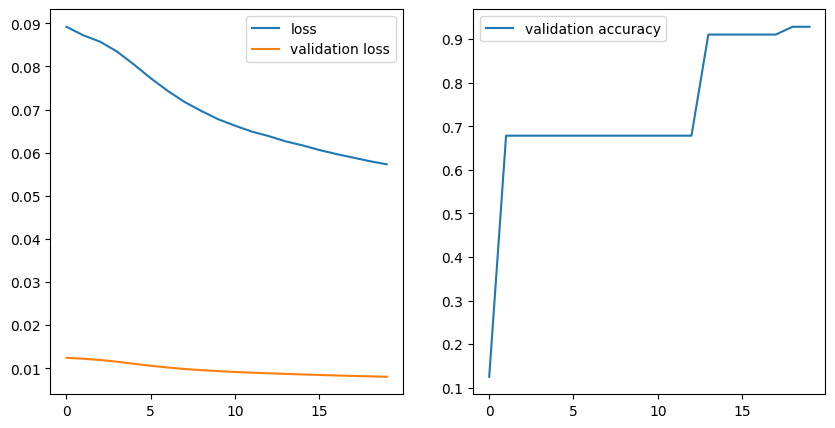

dropped: 2, test: loss: 0.46469998359680176, accuracy: 0.9593023061752319


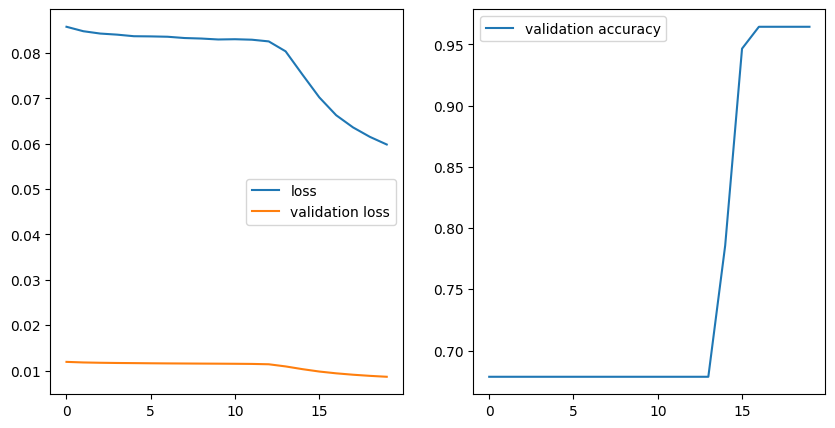

dropped: 3, test: loss: 0.46861886978149414, accuracy: 0.9767441749572754


In [ ]:
# Layer 2
hs = 32 - num_drop_neurons
state_dict = base_model.state_dict()
criterion = nn.CrossEntropyLoss()
model_factory = lambda x, y: MLP(x, (hs, y), 2)
optimizer_factory = lambda model: optim.Adam(model.parameters(), lr=0.001)
test_accs, dropped_neurons, models = fast_remove_neurons(reduced_datasets_neurons_layer1, hs, model_factory, optimizer_factory, criterion, False)